# System & Data

In [1]:
import sys
import os
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
from tqdm import tqdm
import pandas as pd
import autograd.numpy as np
import torch
from scipy.integrate import solve_ivp
import autograd
import math
import random

In [2]:
class DoublePendulum:
    def __init__(self, g=9.81, m1=1, m2=1, l1=1, l2=1):
        self.n_particles = 2
        self.g = g
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
   
    def get_hamiltonian(self, coords):
        q1, q2, p1, p2 = np.split(coords, self.n_particles * 2)

        w1, w2 = self.get_angular_velocities(q1, q2, p1, p2)

        t1 = 0.5 * self.m1 * (self.l1 ** 2) * (w1 ** 2)
        u1 = -1 * self.m1 * self.g * self.l1 * np.cos(q1)

        t2 = 0.5 * self.m2 * ((self.l1 ** 2) * (w1 ** 2) + (self.l2 ** 2)
                              * (w2 ** 2) + 2 * self.l1*self.l2*np.cos(q1-q2)*w1*w2)
        u2 = -1 * self.m2 * self.g * \
            (self.l1 * np.cos(q1) + self.l2 * np.cos(q2))

        return t1 + u1 + t2 + u2

    def get_dynamics(self, t, coords):
        derivatives = autograd.grad(self.get_hamiltonian)(coords)
        dHdq, dHdp = np.split(derivatives, 2)
        return np.concatenate([dHdp, -dHdq], axis=-1)

    def get_initial(self):
        y0 = np.random.rand(self.n_particles * 2) * 2 * np.pi - np.pi
        y0[2], y0[3] = 0, 0

        return y0

    def get_cartesian(self, coords):
        x1 = self.l1 * np.sin(coords[0])
        y1 = -self.l1 * np.cos(coords[0])
        x2 = x1 + self.l2 * np.sin(coords[1])
        y2 = y1 - self.l2 * np.cos(coords[1])

        return x1, y1, x2, y2

    def get_angular_velocities(self, q1, q2, p1, p2):
        C = self.l1 * self.l2 * (self.m1 + self.m2 * np.sin(q1 - q2)**2)

        w1 = (self.l2 * p1 - self.l1 * p2 * np.cos(q1 - q2)) / (self.l1 * C)
        w2 = (self.l1 * (self.m1 + self.m2) * p2 - self.l2 *
              self.m2 * p1 * np.cos(q1 - q2)) / (self.l2 * self.m2 * C)

        return w1, w2

    def get_trajectory(self, time_span=[0, 10], timescale=10, noise_std=0.0, y0=None, **kwargs):
        evaluation_time = np.linspace(time_span[0], time_span[1], int(
            timescale * (time_span[1] - time_span[0])))

        if y0 is None:
            y0 = self.get_initial()

        solution = solve_ivp(fun=self.get_dynamics, t_span=time_span,
                             y0=y0, t_eval=evaluation_time, rtol=1e-5, atol=1e-5, **kwargs)

        y = solution['y']
        y += np.random.randn(*y.shape) * noise_std

        dydt = [self.get_dynamics(None, y) for y in solution['y'].T]
        dydt = np.stack(dydt).T

        return y, dydt, evaluation_time

    def get_dataset(self, samples=100, test_split=0.8, **kwargs):
        xs, dxs = [], []
        for _ in tqdm(range(samples)):
            x, dx, t = self.get_trajectory(**kwargs)
            xs.append(x.T)
            dxs.append(dx.T)

        split_idx = int(samples * test_split)

        xs = np.float32(xs)
        dxs = np.float32(dxs)

        train_x = torch.tensor(
            xs[:split_idx], requires_grad=True)
        train_y = torch.tensor(dxs[:split_idx])
        test_x = torch.tensor(
            xs[split_idx:], requires_grad=True)
        test_y = torch.tensor(dxs[split_idx:])

        train_x = torch.reshape(
            train_x, (train_x.shape[0] * train_x.shape[1], train_x.shape[2]))
        train_y = torch.reshape(
            train_y, (train_y.shape[0] * train_y.shape[1], train_y.shape[2]))
        test_x = torch.reshape(
            test_x, (test_x.shape[0] * test_x.shape[1], test_x.shape[2]))
        test_y = torch.reshape(
            test_y, (test_y.shape[0] * test_y.shape[1], test_y.shape[2]))

        return train_x, train_y, test_x, test_y

## Obtain Dataset and Save It (no need to rerun)

In [55]:
# get instance of the system
system = DoublePendulum()
DATAPOINTS = 1000

generate_dataset = False 
if generate_dataset:
    train_x, train_y, test_x, test_y = system.get_dataset(DATAPOINTS)
    torch.save(train_x, f'data/{DATAPOINTS}_train_x.pkl')
    torch.save(train_y, f'data/{DATAPOINTS}_train_y.pkl')
    torch.save(test_x, f'data/{DATAPOINTS}_test_x.pkl')
    torch.save(test_y, f'data/{DATAPOINTS}_test_y.pkl')

# Loading data

In [4]:
train_x, train_y, test_x, test_y = torch.load(f'data/{DATAPOINTS}_train_x.pkl'), torch.load(f'data/{DATAPOINTS}_train_y.pkl'), torch.load(f'data/{DATAPOINTS}_test_x.pkl'), torch.load(f'data/{DATAPOINTS}_test_y.pkl')

In [5]:
extra_train_x = torch.load(f'data/{DATAPOINTS}_train_x.pkl')

In [6]:
train_x.shape

torch.Size([8000, 4])

<Figure size 640x480 with 0 Axes>

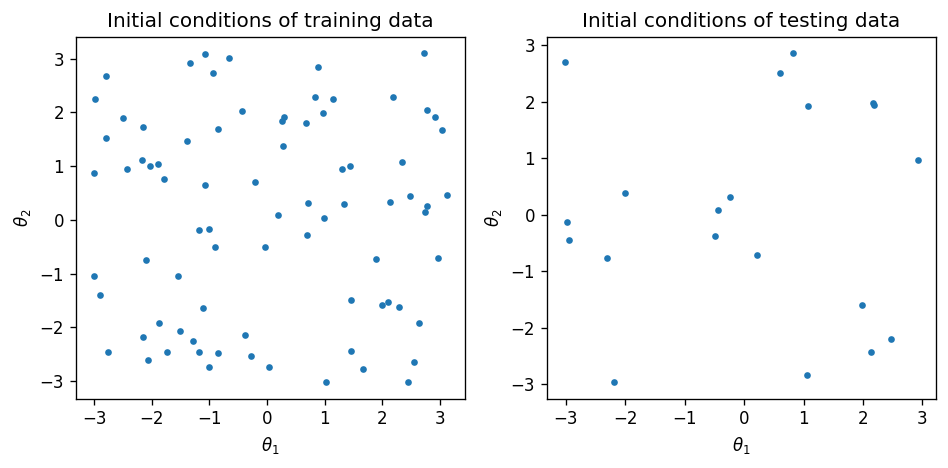

In [7]:
# Initial conditions of test and train data
fig = plt.figure()

ic_test_x, ic_test_y = torch.hsplit(test_x[::100,0:2],2)
ic_train_x, ic_train_y = torch.hsplit(train_x[::100,0:2],2)

ic_test_x = ic_test_x.detach().numpy()[:,0]
ic_test_y = ic_test_y.detach().numpy()[:,0]
ic_train_x = ic_train_x.detach().numpy()[:,0]
ic_train_y = ic_train_y.detach().numpy()[:,0]

#plot

SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Initial conditions of training data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.scatter(ic_train_x,ic_train_y, marker = '.')

plt.subplot(1,2,2)
plt.title("Initial conditions of testing data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.scatter(ic_test_x,ic_test_y, marker = '.')

plt.tight_layout()
plt.savefig("Initial_conditions")

# Networks

# Parent MLP

In [56]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers = 2):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(input_dim, hidden_dim))
        for _ in range(num_hidden_layers - 1):
            self.layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(torch.nn.Linear(hidden_dim, output_dim, bias=None))

        self.activation = torch.tanh

    def forward(self, x):
        h = x.clone()
        for layer in self.layers[:-1]:
            h = self.activation(layer(h))
        return self.layers[-1](h)

# Hamiltonian Neural Network

In [57]:

class HNN(torch.nn.Module):
    def __init__(self, model):
        super(HNN, self).__init__()

        self.model = model
        self.M = self.get_symplectic_tensor(model.input_dim)

    def forward(self, x):
        return self.model(x)

    def time_derivative(self, x):
        copy = x.clone() # copy the input
        # keep angles withing -PI, PI
        copy[:, 0] = torch.remainder(x[:, 0]+torch.pi, 2*torch.pi)-torch.pi
        copy[:, 1] = torch.remainder(x[:, 1]+torch.pi, 2*torch.pi)-torch.pi
        H = self.forward(copy)
        dH = torch.autograd.grad(H.sum(), copy, create_graph=True)[0]

        return dH @ self.M.t()
 
    def integrate(self, time_span, y0, fun=None, timescale=40, **kwargs):
        def fun(t, np_x):
            x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
            x = x.view(1, np.size(np_x))  # batch size of 1
            dx = self.time_derivative(x).data.numpy().reshape(-1)
            return dx

        t_eval = np.linspace(time_span[0], time_span[1], int(
            timescale * (time_span[1] - time_span[0])))
        return solve_ivp(fun=fun, t_span=time_span, t_eval=t_eval, y0=y0, rtol=1e-10)['y']

    def train(self, train_x, train_y, val_x, val_y, lr=1e-3, epochs=100, batch_size=32, patience=10, verbose=False,
            print_step=50, weight_decay=1e-4, device='cpu'):
        optim = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        stats = {"loss": [], "val_loss": []}
        best_val_loss = float("inf")
        counter = 0

        num_batches = len(train_x) // batch_size

        for epoch in range(epochs):
            epoch_loss = 0.0

            # Training phase
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = (batch_idx + 1) * batch_size

                batch_x = train_x[start_idx:end_idx].to(device)
                batch_y = train_y[start_idx:end_idx].to(device)

                y_hat = self.time_derivative(batch_x)
                y_hat_new = y_hat.clone()
                loss = (batch_y - y_hat_new).pow(2).mean()

                loss.backward()
                optim.step()
                optim.zero_grad()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / num_batches
            stats["loss"].append(avg_loss)

            # Validation phase
            val_y_hat = self.time_derivative(val_x.to(device))
            val_loss = (val_y.to(device) - val_y_hat).pow(2).mean()
            stats["val_loss"].append(val_loss.item())

            if verbose and epoch % print_step == 0:
                print(f"Epoch {epoch}, Loss {avg_loss}, Val Loss {val_loss.item()}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch}.")
                    break

        return stats
    
    def test(self, test_x, test_y):
        y_hat = self.time_derivative(test_x)
        loss = ((test_y - y_hat)).pow(2).mean()

        return loss.item()

    def get_symplectic_tensor(self, n):
        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])

        return M

In [10]:
np.random.seed(2023)
torch.manual_seed(2023)

split_index = int(0.8 * len(train_x))
train_x_sub = train_x[:split_index]
val_x = train_x[split_index:]

split_index = int(0.8 * len(train_y))
train_y_sub = train_y[:split_index]
val_y = train_y[split_index:]

In [59]:
model = MLP(4, 256, 1, 4)
hnn = HNN(model)

filepath = "models/HNN_model"
if not os.path.exists(filepath):
    hnn.train(train_x_sub, train_y_sub, val_x, val_y, weight_decay=0.01, verbose=True, batch_size=32, patience=100)
    torch.save(hnn.state_dict(), filepath)
else:
    hnn.load_state_dict(torch.load(filepath))
print(hnn.test(test_x, test_y))

4.436582088470459


# Derivative Baseline

In [12]:

class Baseline(torch.nn.Module):
    def __init__(self, model):
        super(Baseline, self).__init__()

        self.model = model

    def forward(self, x):
        return self.model(x)

    def time_derivative(self, x):
        copy = x.clone()

        copy[:, 0] = torch.remainder(x[:, 0]+torch.pi, 2*torch.pi)-torch.pi
        copy[:, 1] = torch.remainder(x[:, 1]+torch.pi, 2*torch.pi)-torch.pi

        return self.forward(copy)
 
    def integrate_model(self, time_span, y0, fun=None, timescale=40, **kwargs):
        def fun(t, np_x):
            x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
            x = x.view(1, np.size(np_x))  # batch size of 1
            dx = self.time_derivative(x).data.numpy().reshape(-1)
            return dx

        t_eval = np.linspace(time_span[0], time_span[1], int(
            timescale * (time_span[1] - time_span[0])))
        return solve_ivp(fun=fun, t_span=time_span, t_eval=t_eval, y0=y0, rtol=1e-10)['y']

    def train(self, train_x, train_y, val_x, val_y, lr=1e-3, epochs=100, batch_size=32, patience=10, verbose=False,
            print_step=50, weight_decay=1e-4, device='cpu'):
        optim = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        stats = {"loss": [], "val_loss": []}
        best_val_loss = float("inf")
        counter = 0

        num_batches = len(train_x) // batch_size

        for epoch in range(epochs):
            epoch_loss = 0.0

            # Training phase
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = (batch_idx + 1) * batch_size

                batch_x = train_x[start_idx:end_idx].to(device)
                batch_y = train_y[start_idx:end_idx].to(device)

                y_hat = self.time_derivative(batch_x) # --> we just forward instead of getting derivative of the hamiltonian and all the good stuff
                loss = ((batch_y - y_hat)).pow(2).mean()

                loss.backward()
                optim.step()
                optim.zero_grad()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / num_batches
            stats["loss"].append(avg_loss)

            # Validation phase
            val_y_hat = self.time_derivative(val_x.to(device))
            val_loss = ((val_y.to(device) - val_y_hat)).pow(2).mean()
            stats["val_loss"].append(val_loss.item())

            if verbose and epoch % print_step == 0:
                print(f"Epoch {epoch}, Loss {avg_loss}, Val Loss {val_loss.item()}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch}.")
                    break

        return stats


    def test(self, test_x, test_y):

        stats = {"loss": []}

        y_hat = self.time_derivative(test_x)

        loss = ((test_y-y_hat)).pow(2).mean()

        return loss.item()

In [51]:
model = MLP(4, 256, 4, 4)
baseline = Baseline(model)

filepath = "models/Baseline_model"
if not os.path.exists(filepath):
    baseline.train(train_x_sub, train_y_sub, val_x, val_y, weight_decay=1E-5, verbose=True, batch_size=4, patience=100, print_step=10)
    torch.save(baseline.state_dict(), filepath)
else:
    baseline.load_state_dict(torch.load(filepath))
print(baseline.test(test_x, test_y))

4.893528938293457


# Time Difference Baseline

In [15]:

class TimeDiff(torch.nn.Module):
    def __init__(self, model):
        super(TimeDiff, self).__init__()

        self.model = model

    def forward(self, x):
        copy = x.clone()
        copy = copy.view(-1, 4)
        copy[:, [0, 1]] = torch.remainder(copy[:, [0, 1]]+torch.pi, 2*torch.pi)-torch.pi # safety modulo 2 pi
        return self.model(copy)
    
    def integrate_model(self, time_span, y0, fun=None, timescale=40, **kwargs):
        t_eval = np.linspace(time_span[0], time_span[1], int(
            timescale * (time_span[1] - time_span[0])))
        data = []
        y0 = torch.FloatTensor([y0]) 
        for _ in t_eval:
            data.append(y0)
            y0 = self.forward(y0)
            
        transformed_data = np.array([np.array(tensor.tolist())[0] for tensor in data]).T
        return transformed_data
    
    def transform_dataset(self, train_x, train_y):
        """
        This function shifts the training data by one to create time difference to train on.
        :param train_x: training data [theta1, theta2, p1, p2]
        :param train_y: training data [theta1/dt, theta2/dt, p1/dt, p2/dt] - this is ignored
        """
        num_rows, _ = train_x.size()
        train_x = train_x[1:]
        train_y = train_y[:num_rows-1]
        return train_x, train_y


    def train(self, train_x, train_y, val_x, val_y, lr=1e-3, epochs=100, batch_size=32, patience=10, verbose=False, print_step=50, weight_decay=1e-4, device='cpu'):
        train_x, train_y = self.transform_dataset(train_x, train_y)
        optim = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        stats = {"loss": [], "val_loss": []}
        best_val_loss = float("inf")
        counter = 0

        num_batches = len(train_x) // batch_size

        for epoch in range(epochs):
            epoch_loss = 0.0

            # Training phase
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = (batch_idx + 1) * batch_size

                batch_x = train_x[start_idx:end_idx].to(device)
                batch_y = train_y[start_idx:end_idx].to(device)

                y_hat = self.forward(batch_x)
                loss = ((batch_y - y_hat)).pow(2).mean()

                loss.backward()
                optim.step()
                optim.zero_grad()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / num_batches
            stats["loss"].append(avg_loss)

            # Validation phase
            val_y_hat = self.forward(val_x.to(device))
            val_loss = ((val_y.to(device) - val_y_hat)).pow(2).mean()
            stats["val_loss"].append(val_loss.item())

            if verbose and epoch % print_step == 0:
                print(f"Epoch {epoch}, Loss {avg_loss}, Val Loss {val_loss.item()}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch}.")
                    break

        return stats
    
    def test(self, test_x, test_y):
        test_x, test_y = self.transform_dataset(test_x, test_y)
        stats = {"loss": []}

        y_hat = self.forward(test_x)

        loss = (test_y-y_hat).pow(2).mean()

        return loss.item()

In [54]:
model = MLP(4, 256, 4, 4)
time_diff = TimeDiff(model)

filepath = "models/TimeDiff_model"
if not os.path.exists(filepath):
    time_diff.train(train_x_sub, train_y_sub, val_x, val_y, weight_decay=1e-2, verbose=True, batch_size=32, patience=100, print_step=10)
    torch.save(time_diff.state_dict(), filepath)
else:
    time_diff.load_state_dict(torch.load(filepath))
print(time_diff.test(test_x, test_y))

4.518853664398193


# Physics Informed Neural Network

In [69]:

class PINN(TimeDiff):
    def __init__(self, model):
        super(PINN, self).__init__(model)
        self.l1 = 1
        self.l2 = 1
        self.m1 = 1
        self.m2 = 1
        self.g = 9.81
    
    def forward(self, x):
        copy = x.clone()
        copy = copy.view(-1, 4)
        copy[:, [0, 1]] = torch.remainder(copy[:, [0, 1]]+torch.pi, 2*torch.pi)-torch.pi # safety modulo 2 pi
        return self.model(copy)
    
    def integrate_model(self, time_span, y0, fun=None, timescale=40, **kwargs):
        t_eval = np.linspace(time_span[0], time_span[1], int(
            timescale * (time_span[1] - time_span[0])))
        data = []
        y0 = torch.FloatTensor([y0]) 
        for _ in t_eval:
            data.append(y0)
            y0 = self.forward(y0)
        transformed_data = np.array([np.array(tensor.tolist())[0] for tensor in data]).T
        return transformed_data

    def get_hamiltonian(self, coords):
        q1, q2, p1, p2 = torch.hsplit(coords, 4)
        w1, w2 = self.get_angular_velocities(q1, q2, p1, p2)
        
        t1 = 0.5 * self.m1 * (self.l1 ** 2) * (w1 ** 2)
        u1 = -1 * self.m1 * self.g * self.l1 * torch.cos(q1)
        
        t2 = 0.5 * self.m2 * ((self.l1 ** 2) * (w1 ** 2) + (self.l2 ** 2)
                              * (w2 ** 2) + 2 * self.l1*self.l2*torch.cos(q1-q2)*w1*w2)
        u2 = -1 * self.m2 * self.g * \
            (self.l1 * torch.cos(q1) + self.l2 * torch.cos(q2))

        return t1 + u1 + t2 + u2

    def get_angular_velocities(self, q1, q2, p1, p2):
        C = self.l1 * self.l2 * (self.m1 + self.m2 * (torch.sin(q1 - q2))**2)
        w1 = (self.l2 * p1 - self.l1 * p2 * torch.cos(q1 - q2)) / (self.l1 * C)
        w2 = (self.l1 * (self.m1 + self.m2) * p2 - self.l2 *
              self.m2 * p1 * torch.cos(q1 - q2)) / (self.l2 * self.m2 * C)
        return w1, w2
    
    def transform_dataset(self, train_x, train_y):
        """
        This function shifts the training data by one to create time difference to train on.
        :param train_x: training data [theta1, theta2, p1, p2]
        :param train_y: training data [theta1/dt, theta2/dt, p1/dt, p2/dt] - this is ignored
        """
        num_rows, _ = train_x.size()
        train_x = train_x[1:]
        train_y = train_x[:num_rows-1]
        return train_x, train_y

    # Alpha changes the relative preference between energy conservation and usual training loss
    def train(self, train_x, train_y, val_x, val_y, lr=1e-3, epochs=100, batch_size=32, patience=10, verbose=False, print_step=50, weight_decay=1e-4, alpha=0.1, device='cpu'):
        train_x, train_y = self.transform_dataset(train_x, train_y)
        optim = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        stats = {"loss": [], "val_loss": []}
        best_val_loss = float("inf")
        counter = 0

        num_batches = len(train_x) // batch_size

        for epoch in range(epochs):
            epoch_loss = 0.0

            # Training phase
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = (batch_idx + 1) * batch_size

                batch_x = train_x[start_idx:end_idx].to(device)
                batch_y = train_y[start_idx:end_idx].to(device)

                y_hat = self.forward(batch_x)
                loss = (batch_y-y_hat).pow(2).mean()+alpha*(self.get_hamiltonian(y_hat)-self.get_hamiltonian(batch_y)).pow(2).mean()

                loss.backward()
                optim.step()
                optim.zero_grad()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / num_batches
            stats["loss"].append(avg_loss)

            # Validation phase
            val_y_hat = self.forward(val_x.to(device))
            val_loss = ((val_y.to(device) - val_y_hat)).pow(2).mean()
            stats["val_loss"].append(val_loss.item())

            if verbose and epoch % print_step == 0:
                print(f"Epoch {epoch}, Loss {avg_loss}, Val Loss {val_loss.item()}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch}.")
                    break

        return stats
    
    def test(self, test_x, test_y):
        test_x, test_y = self.transform_dataset(test_x, test_y)
        stats = {"loss": []}

        y_hat = self.forward(test_x)

        loss = (test_y-y_hat).pow(2).mean()

        return loss.item()

In [71]:
model = MLP(4, 254, 4, 4)
pinn = PINN(model)

filepath = "models/PINN_model"
if not os.path.exists(filepath):
    pinn.train(train_x_sub, train_y_sub, val_x, val_y, weight_decay=0.001, verbose=True, alpha=0.2, patience=100, batch_size=2, print_step=10)
    torch.save(pinn.state_dict(), filepath)
else:
    pinn.load_state_dict(torch.load(filepath))
print(pinn.test(test_x, test_y))

43.27309799194336


# Plots

In [19]:
np.random.seed(2140)

time_span=[0,4]
y, dy, t = system.get_trajectory(time_span=time_span, noise_std=0.0, timescale=10)
y0 = y[:,0]

print(y0)

[ 1.70308406 -0.78506748  0.          0.        ]


In [20]:
predicted_trajectory_baseline = baseline.integrate_model(time_span=time_span, y0=y0, timescale=10)

In [21]:
predicted_trajectory_time_diff = time_diff.integrate_model(time_span=time_span, y0=y0, timescale=10)

/var/folders/1r/0l1sdxpx77gc_0wwcq9250n00000gn/T/ipykernel_18706/1552648200.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  y0 = torch.FloatTensor([y0])


In [22]:
predicted_trajectory_pinn = pinn.integrate_model(time_span=time_span, y0=y0, timescale=10) ## fake PINN

In [23]:
predicted_trajectory = hnn.integrate_model(time_span=time_span, y0=y0, timescale=10)

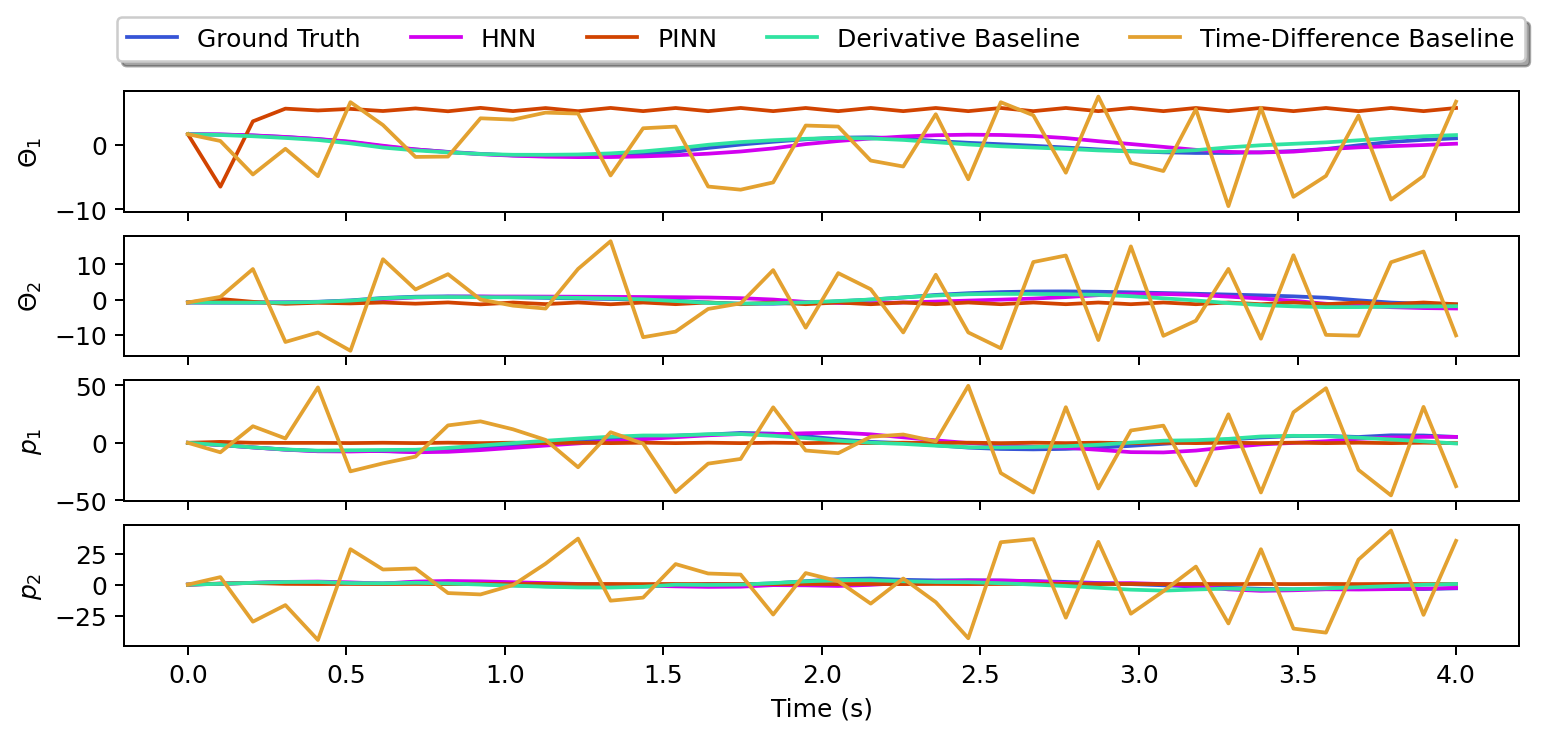

In [24]:
fig, axs = plt.subplots(4, sharex=True, figsize=(10,4), dpi=180)

colors = {
    'true' : '#3654D6',
    'baseline': '#30E3A1',
    'time_diff': '#E3a130',
    'pinn':'#D14300',
    'hnn' : '#D200F0',
    'rhnn': '#F0C444'
}


axs[0].plot(t, y[0], color=colors['true'])
axs[0].plot(t, predicted_trajectory[0], color=colors['hnn'])
axs[0].plot(t, predicted_trajectory_pinn[0], color=colors['pinn'])
axs[0].plot(t, predicted_trajectory_baseline[0], color=colors['baseline'])
axs[0].plot(t, predicted_trajectory_time_diff[0], color=colors['time_diff'])
axs[0].set_ylabel("$\Theta_1$")

axs[1].plot(t, y[1], color=colors['true'])
axs[1].plot(t, predicted_trajectory[1], color=colors['hnn'])
axs[1].plot(t, predicted_trajectory_pinn[1], color=colors['pinn'])
axs[1].plot(t, predicted_trajectory_baseline[1], color=colors['baseline'])
axs[1].plot(t, predicted_trajectory_time_diff[1], color=colors['time_diff'])
axs[1].set_ylabel("$\Theta_2$")

axs[2].plot(t, y[2], color=colors['true'])
axs[2].plot(t, predicted_trajectory[2], color=colors['hnn'])
axs[2].plot(t, predicted_trajectory_pinn[2], color=colors['pinn'])
axs[2].plot(t, predicted_trajectory_baseline[2], color=colors['baseline'])
axs[2].plot(t, predicted_trajectory_time_diff[2], color=colors['time_diff'])
axs[2].set_ylabel("$p_1$")

axs[3].plot(t, y[3], color=colors['true'], label="Ground Truth")
axs[3].plot(t, predicted_trajectory[3], color=colors['hnn'], label="HNN")
axs[3].plot(t, predicted_trajectory_pinn[3], color=colors['pinn'], label="PINN")
axs[3].plot(t, predicted_trajectory_baseline[3], color=colors['baseline'], label="Derivative Baseline")
axs[3].plot(t, predicted_trajectory_time_diff[3], color=colors['time_diff'], label="Time-Difference Baseline")
axs[3].set_ylabel("$p_2$")
axs[3].set_xlabel("Time (s)")


handles, labels = axs[3].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.91, 1.0),
          ncol=5, fancybox=True, shadow=True)

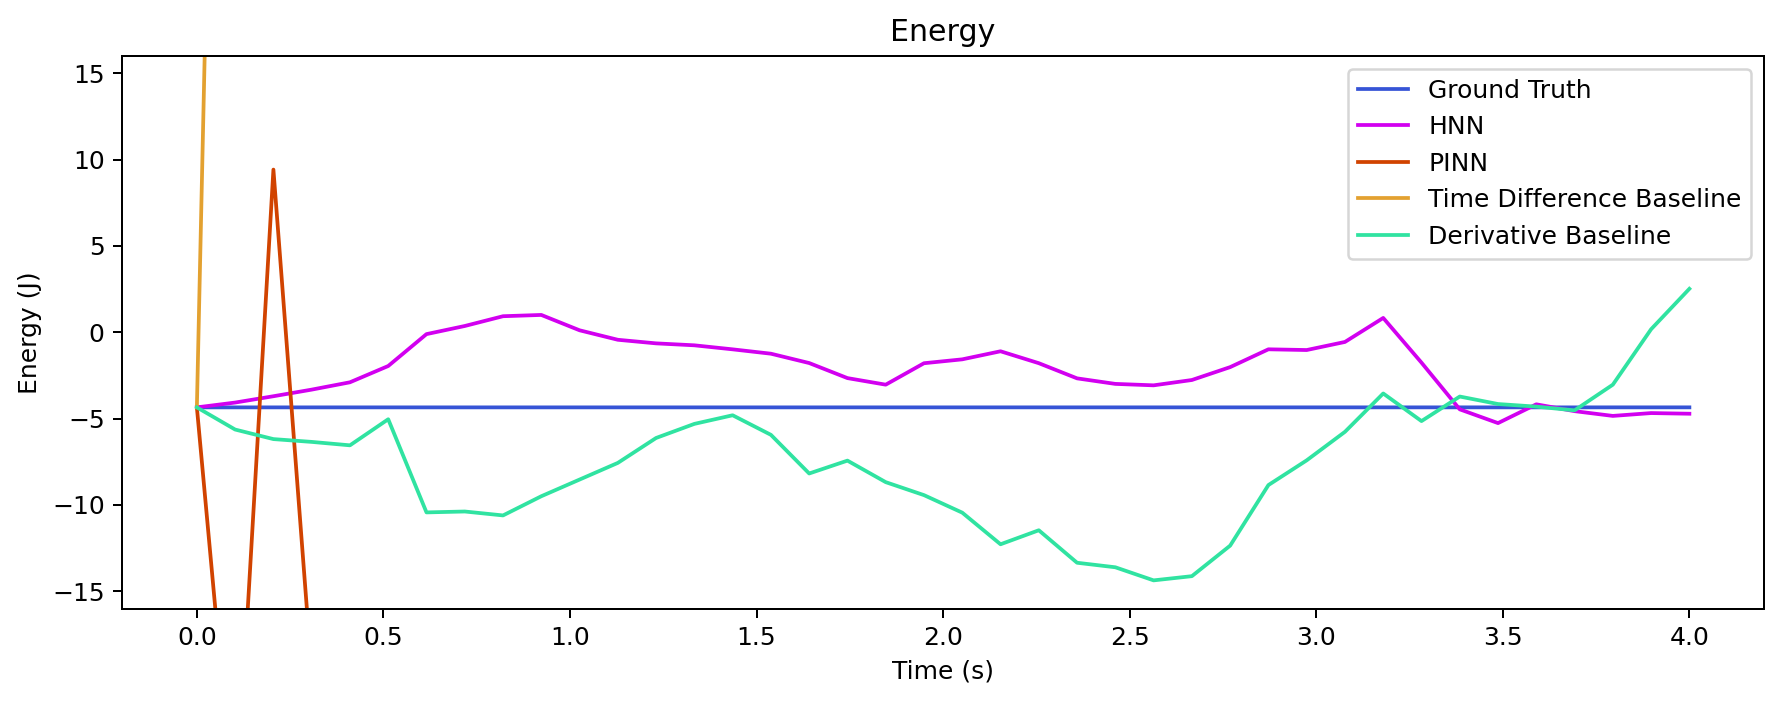

In [25]:
true_hamiltonians = []
pred_hamiltonians = [[],[],[],[]]

true_energy = []
pred_energies = [[],[],[],[]]

y_hats = [predicted_trajectory, predicted_trajectory_pinn, predicted_trajectory_time_diff, predicted_trajectory_baseline]

for i, _ in enumerate(y[0]):
    true_coords = np.float32([y[0, i], y[1, i], y[2, i], y[3, i]])
    pred_coords = [np.float32([y_hats[j][0, i], y_hats[j][1, i], y_hats[j][2, i], y_hats[j][3, i]]) for j in range(4)]
    
    true_energy.append(system.get_hamiltonian(true_coords))
    true_hamiltonians.append(hnn.forward(torch.tensor(true_coords)))
    for j in range(4): 
        pred_hamiltonians[j].append(hnn.forward(torch.tensor(pred_coords[j])))
        pred_energies[j].append(system.get_hamiltonian(pred_coords[j]))


fig, ax = plt.subplots(1,figsize=(10,4), dpi=180)
ax.plot(t, true_energy, label="Ground Truth", color=colors['true'])
ax.plot(t, pred_energies[0], label="HNN", color=colors['hnn'])
ax.plot(t, pred_energies[1], label="PINN", color=colors['pinn'])
ax.plot(t, pred_energies[2], label="Time Difference Baseline", color=colors['time_diff'])
ax.plot(t, pred_energies[3], label="Derivative Baseline", color=colors['baseline'])

ax.set_title("Energy")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Energy (J)")
ax.set_ylim(-16,16)

ax.legend(loc='upper right')
plt.tight_layout()

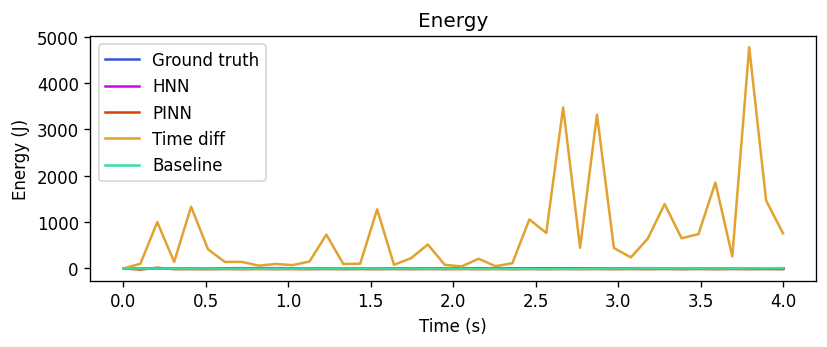

In [26]:
true_hamiltonians = []
pred_hamiltonians = [[],[],[],[]]

y_hats = [predicted_trajectory, predicted_trajectory_pinn, predicted_trajectory_time_diff, predicted_trajectory_baseline]

for i, _ in enumerate(y[0]):
    true_coords = np.float32([y[0, i], y[1, i], y[2, i], y[3, i]])
    pred_coords = [np.float32([y_hats[j][0, i], y_hats[j][1, i], y_hats[j][2, i], y_hats[j][3, i]]) for j in range(4)]
    
    true_hamiltonians.append(system.get_hamiltonian(true_coords))
    for j in range(4): pred_hamiltonians[j].append(system.get_hamiltonian(pred_coords[j]))


# min_energy = np.min([np.min(true_hamiltonians),np.min(pred_hamiltonians)])-10
fig, ax = plt.subplots(figsize=(7,3), dpi=120)

ax.plot(t, true_hamiltonians, label="Ground truth", color=colors['true'])
ax.plot(t, pred_hamiltonians[0], label="HNN", color=colors['hnn'])
ax.plot(t, pred_hamiltonians[1], label="PINN", color=colors['pinn'])
ax.plot(t, pred_hamiltonians[2], label="Time diff", color=colors['time_diff'])
ax.plot(t, pred_hamiltonians[3], label="Baseline", color=colors['baseline'])


ax.set_title("Energy")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Energy (J)")
ax.legend()
plt.tight_layout()

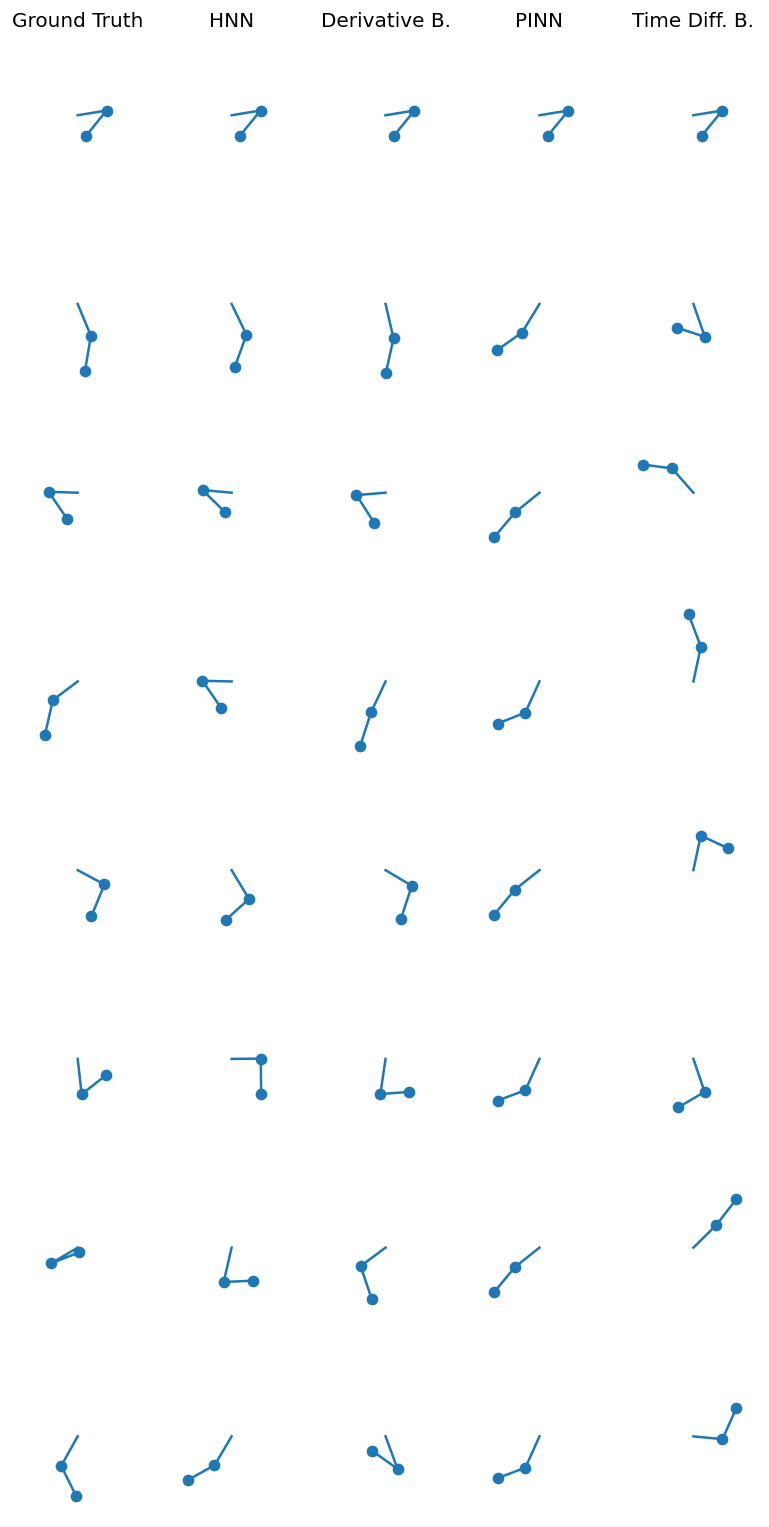

In [27]:
timesteps = 8
dt = t[-1] / timesteps
y_hats = [predicted_trajectory, predicted_trajectory_baseline, predicted_trajectory_pinn, predicted_trajectory_time_diff]

fig, axs = plt.subplots(timesteps, 5, sharex=True, sharey=True, figsize=(8,2 * timesteps),dpi=120)

axs[0,0].set_title("Ground Truth")
axs[0,1].set_title("HNN")
axs[0,2].set_title("Derivative B.")
axs[0,3].set_title("PINN")
axs[0,4].set_title("Time Diff. B.")

for plot_idx, i in enumerate([i for i in range(0, len(y[0]), len(y[0]) // (timesteps))]):
    true_coords = np.float32([y[0, i], y[1, i], y[2, i], y[3, i]])
    preds_coords = [np.float32([y_hats[j][0, i], y_hats[j][1, i], y_hats[j][2, i], y_hats[j][3, i]]) for j in range(4)]
    
    true_cartesian = system.get_cartesian(true_coords)
    preds_cartesian = [system.get_cartesian(coords) for coords in preds_coords]
    
    for i in range(5):
        axs[plot_idx,i].set_xlim(-2.2,2.2)
        axs[plot_idx,i].set_ylim(-2.2,2.2)
        axs[plot_idx,i].axis('off')
    
    axs[plot_idx,0].set_ylabel(f"T={(plot_idx + 1) * dt}")
    
    axs[plot_idx,0].scatter([true_cartesian[0], true_cartesian[2]], [true_cartesian[1], true_cartesian[3]])
    axs[plot_idx,0].plot([0,true_cartesian[0], true_cartesian[2]], [0,true_cartesian[1], true_cartesian[3]])
    
    for j in range(4):
        axs[plot_idx,j+1].scatter([preds_cartesian[j][0], preds_cartesian[j][2]], [preds_cartesian[j][1], preds_cartesian[j][3]])  
        axs[plot_idx,j+1].plot([0,preds_cartesian[j][0], preds_cartesian[j][2]], [0,preds_cartesian[j][1], preds_cartesian[j][3]]) 

plt.savefig("trajectories steps.png")

In [28]:
def get_time_to_flip(y, t):
    for pos, time in zip(y[1], t):
        if pos < -np.pi - 0.05 or pos > np.pi + 0.05:
            return time
    return t[-1]

In [29]:
def get_last_analyzed(times):
    for i, row in enumerate(times):
        for j, t in enumerate(row):
            if t == 0:
                return i, j
            
    return times.shape

In [30]:
import os

resolution = 25
angles = np.linspace(-np.pi, np.pi, resolution)

initial_conditions = []
times_hnn = np.zeros(shape=(resolution,resolution), dtype=np.float32)
trajectories = []

path = "results/time_diff/chaos.npy"
start_i, start_j = 0,0
if os.path.exists(path):
    times_hnn = np.load(path)
    start_i, start_j = get_last_analyzed(times_hnn)
    print(f"Continuing from {start_i, start_j}")

for i, th1 in enumerate(angles):
    if i < start_i:
        continue
    for j, th2 in enumerate(angles):
        if i == start_i and j < start_j:
            continue
        print(f"{i+1}/{resolution}, {j+1}/{resolution}")
        y0 = np.float32([th1, th2, 0, 0])
        times_hnn[i,j] = 15
        for k in range(1, 15, 1):
            print(k)
            y = time_diff.integrate_model(time_span=[0,1], y0=y0, timescale=10)
            t = np.linspace(k, k+1, 10)
            flip_time = get_time_to_flip(y, t)
            y0 = y[:,-1]
            if flip_time < k+1:
                times_hnn[i,j] = flip_time
                break
        print('Time:',times_hnn[i, j])
        np.save(path, times_hnn)

Continuing from (25, 25)


# Fancy Plots

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [32]:
times_time_diff = np.load('results/baseline/chaos.npy')

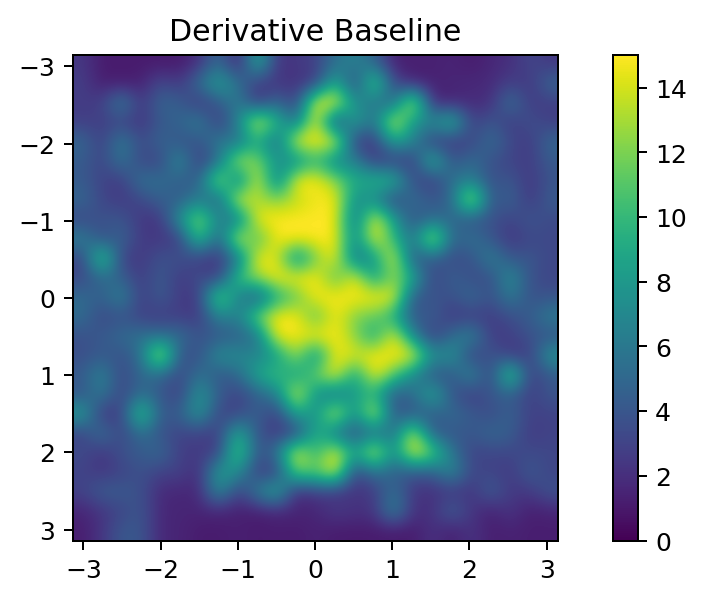

In [33]:
fig, axs = plt.subplots(figsize=(8,3.5), dpi=180, sharey=True)

cmap = 'viridis'

axs.set_xticks([-3,-2,-1,0,1,2,3])
axs.set_title("Derivative Baseline")
im = axs.imshow(times_time_diff.T, vmin=0, vmax=15, cmap=cmap, extent=[-np.pi, np.pi, np.pi, -np.pi],interpolation='bicubic')
plt.colorbar(im)

# Cross-validation

In [34]:
def cross_validation(train_x, train_y, num_folds=5, epochs=500, patience=100, lr=1e-2, print_step=10, hidden_layers=4, nodes=50, model='', weight_decay=1e-4, alpha=1, batch_size=32):
    fold_size = len(train_x) // num_folds
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    performance_metrics = {"loss": []}

    for fold in tqdm(range(num_folds), leave=False):
        # Split data into training and validation sets for this fold
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size

        val_x = train_x[val_start:val_end]
        val_y = train_y[val_start:val_end]

        train_x_fold = torch.concatenate([train_x[:val_start], train_x[val_end:]]) #np.concatenate
        train_y_fold = torch.concatenate([train_y[:val_start], train_y[val_end:]]) #np.concatenate

        # Create a new instance of the network for each fold
        model_fold = MLP(4, nodes, 4, num_hidden_layers=hidden_layers) # <---- needs to be edited to fit what we are testing

        train_x_fold = train_x_fold.to(device)
        train_y_fold = train_y_fold.to(device)
        val_x = val_x.to(device)
        val_y = val_y.to(device)
        model_fold = model_fold.to(device)
        

        if model == 'HNN':
            model_fold = MLP(4, nodes, 1, num_hidden_layers=hidden_layers)
            model_fold = model_fold.to(device)
            nn_fold = HNN(model_fold).to(device)
        elif model == 'Baseline':
            nn_fold = Baseline(model_fold).to(device)
        elif model == 'PINN':
            nn_fold = PINN(model_fold).to(device)
        elif model == 'TimeDiff':
            nn_fold = TimeDiff(model_fold).to(device)
        else:
            print("No model recognized")
            return

        # Train the model on the training set
        if model == 'PINN':
            stats = nn_fold.train(train_x=train_x_fold, train_y=train_y_fold, val_x=val_x, val_y=val_y, epochs=epochs,
                      patience=patience, lr=lr, print_step=print_step, weight_decay=weight_decay, device=device, alpha=alpha, batch_size=batch_size)
        else:
            stats = nn_fold.train(train_x=train_x_fold, train_y=train_y_fold, val_x=val_x, val_y=val_y, epochs=epochs,
                      patience=patience, lr=lr, print_step=print_step, weight_decay=weight_decay, device=device, batch_size=batch_size)
        # Evaluate the model on the validation set
        fold_loss = nn_fold.test(val_x, val_y)
        performance_metrics["loss"].append(fold_loss)

        print(f"Fold {fold + 1} - Loss: {fold_loss}")

    # Calculate average performance across all folds
    avg_performance = {metric: np.mean(performance_metrics[metric]) for metric in performance_metrics}

    return avg_performance

In [ ]:
# Perform cross-validation
avg_performance = cross_validation(train_x, train_y, num_folds=10, epochs=100, lr=1e-3, print_step=10, model="HNN")
print("Average Performance:")
print(avg_performance)

# Parameter grid search

In [ ]:
def append_data_to_file(file_path, data):
    file_exists = os.path.isfile(file_path)
    with open(file_path, 'a') as file:
        if not file_exists:
            file.write('\n')
        file.write(str(data) + '\n')

In [ ]:
directory = "justDecay"

if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
losses = []
models = ['HNN', 'PINN', 'Baseline', 'TimeDiff']
for model in tqdm(models, leave=True, desc=" mod"):
    for weight_decay in tqdm([1e-1, 1e-2, 1e-3, 1e-4, 1e-5], leave=False, desc="decay"):
        for nodes in tqdm([256], leave=False, desc=" size"):
            print(model, weight_decay, nodes)
            if model == "PINN":
                for alpha in tqdm(np.arange(0.0, 1.1, 0.1), desc="alpha", leave=False):
                    mod = cross_validation(train_x, train_y, num_folds=10, epochs=100, patience=100, lr=1E-3, print_step=100, nodes=nodes, weight_decay=weight_decay, model=model, alpha=alpha)
                    triple = (mod['loss'], nodes, weight_decay, alpha)
                    print(triple)
                    losses.append(triple)
                    append_data_to_file(""f"{directory}/hyperparameters_"f"{model}_temp.txt", triple)
            else:
                mod = cross_validation(train_x, train_y, num_folds=10, epochs=100, patience=100, lr=1E-3, print_step=100, nodes=nodes, weight_decay=weight_decay, model=model)
                triple = (mod['loss'], nodes, weight_decay)
                print(triple)
                losses.append(triple)
                append_data_to_file(""f"{directory}/hyperparameters_"f"{model}_temp.txt", triple)

In [ ]:
directory = "decayAndBatch"

if not os.path.exists(directory):
    os.makedirs(directory)

losses = []
models = ['HNN', 'PINN', 'Baseline', 'TimeDiff']
for model in tqdm(models, leave=True, desc=" mod"):
    for weight_decay in tqdm([1e-1, 1e-2, 1e-3, 1e-4, 1e-5], leave=False, desc="decay"):
        for batch_size in tqdm([2, 4, 8, 16, 32], leave=False, desc="batch size"):
            print(model, weight_decay, nodes)
            if model == "PINN":
                for alpha in tqdm(np.arange(0.0, 1.1, 0.1), desc="alpha", leave=False):
                    mod = cross_validation(train_x, train_y, num_folds=10, epochs=100, patience=100, lr=1E-3, print_step=100, nodes=256, weight_decay=weight_decay, model=model, alpha=alpha)
                    triple = (mod['loss'], 256, weight_decay, batch_size, alpha)
                    print(triple)
                    losses.append(triple)
                    append_data_to_file(""f"{directory}/hyperparameters_"f"{model}_temp.txt", triple)
            else:
                mod = cross_validation(train_x, train_y, num_folds=10, epochs=100, patience=100, lr=1E-3, print_step=100, nodes=256, weight_decay=weight_decay, model=model)
                triple = (mod['loss'], 256, weight_decay, batch_size)
                print(triple)
                losses.append(triple)
                append_data_to_file(""f"{directory}/hyperparameters_"f"{model}_temp.txt", triple)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [37]:
def read_triples_from_file(file_path):
    triple_dict = {}
    num_values = None

    with open(file_path, 'r') as file:
        for line in file:
            if len(line) < 3:
                continue
            line = line.strip()[1:-1]  # Remove parentheses
            values = line.split(',')
            if num_values is None:
                num_values = len(values)
            if len(values) == num_values:
                key = tuple([float(values[i].strip()) for i in range(1, num_values)])
                color = float(values[0].strip())

                if key in triple_dict:
                    accumulated_color, count = triple_dict[key]
                    accumulated_color += color
                    count += 1
                    triple_dict[key] = (accumulated_color, count)
                else:
                    triple_dict[key] = (color, 1)

    # Calculate the average color for each key
    triples = []
    for key, value in triple_dict.items():
        accumulated_color, count = value
        average_color = accumulated_color / count
        triples.append((average_color,) + key)

    return triples

In [ ]:
losses = read_triples_from_file("tuning/hyperparameters_PINN_temp.txt")
losses = sorted(losses, key=lambda triple: triple[0])
[print(loss) for loss in losses]

HNN (2.0965808749198915, 256.0, 0.01, 32.0)
[(2.3557609915733337, 256.0, 0.1, 32.0), (2.4068999767303465, 256.0, 0.1, 8.0), (2.541697061061859, 256.0, 0.1, 16.0), (2.7556142449378966, 256.0, 0.1, 4.0), (2.797225332260132, 256.0, 0.01, 8.0)]


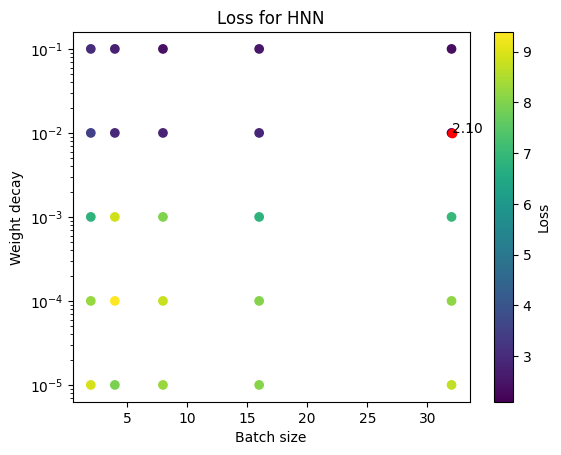

PINN (17.564453506469725, 256.0, 0.01, 32.0, 0.0)
[(17.677563762664796, 256.0, 0.01, 16.0, 0.0), (17.74188361167908, 256.0, 0.01, 8.0, 0.0), (17.785542011260986, 256.0, 0.01, 2.0, 0.0), (17.829832553863525, 256.0, 0.01, 4.0, 0.0), (19.289947319030762, 256.0, 0.1, 4.0, 0.0)]


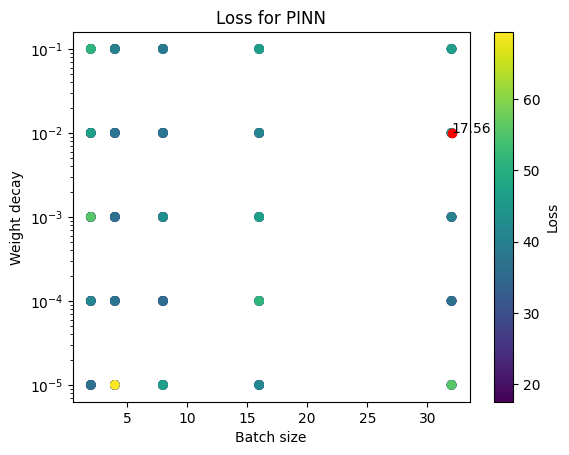

Baseline (2.4656907677650453, 256.0, 1e-05, 4.0)
[(2.478697192668915, 256.0, 0.001, 8.0), (2.4896745562553404, 256.0, 0.0001, 8.0), (2.4951342582702636, 256.0, 0.0001, 16.0), (2.5122359871864317, 256.0, 1e-05, 2.0), (2.5278335094451903, 256.0, 1e-05, 32.0)]


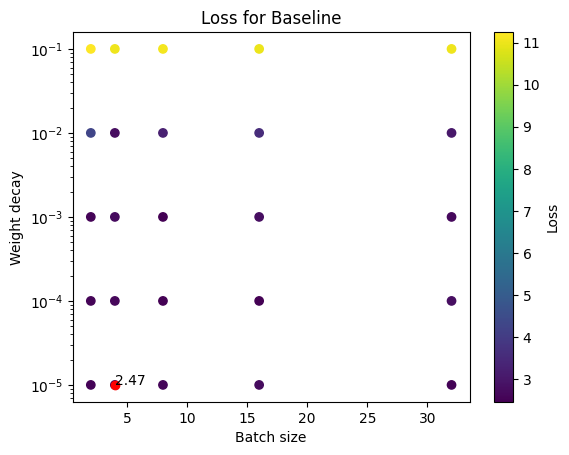

TimeDiff (4.294048380851746, 256.0, 0.0001, 32.0)
[(4.562281966209412, 256.0, 1e-05, 4.0), (4.651680445671081, 256.0, 0.0001, 4.0), (4.836787223815918, 256.0, 0.0001, 2.0), (4.910106635093689, 256.0, 1e-05, 8.0), (4.973636245727539, 256.0, 0.001, 16.0)]


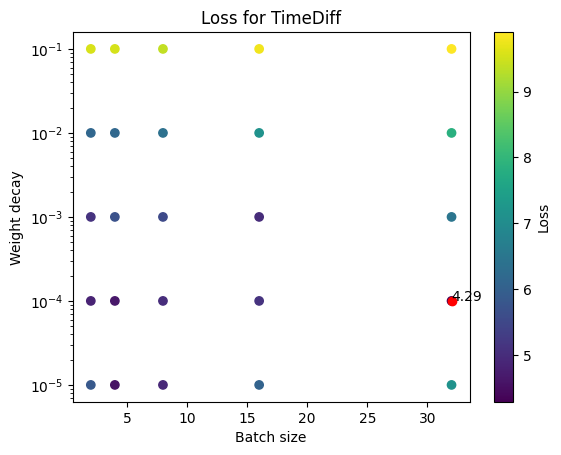

In [38]:
models = ['HNN', 'PINN', 'Baseline', 'TimeDiff']
for model in models:
    fig, ax = plt.subplots()
    losses = read_triples_from_file("tuning/hyperparameters_"f"{model}_temp.txt")
    losses = sorted(losses, key=lambda triple: triple[0])
    print(model, losses[0])
    print(losses[1:6])
    colors = [point[0] for point in losses]
    x = [point[3] for point in losses]
    y = [point[2] for point in losses]
    plt.scatter(x, y, c=colors, cmap='viridis')#, vmin=0)

    cbar = plt.colorbar()
    cbar.set_label('Loss')
    plt.scatter(losses[0][3], losses[0][2], c='r')
    ax.annotate("%.2f" % losses[0][0],
            xy=(losses[0][3], losses[0][2]))


    # Set labels and title
    plt.xlabel('Batch size')
    plt.ylabel('Weight decay')
    plt.yscale('log')
    plt.title('Loss for 'f'{model}')

    plt.savefig("tuning/"f"{model}.png", dpi=200)
    plt.show()

In [ ]:
model = "HNN"
losses = read_triples_from_file("tuning/hyperparameters_"f"{model}_temp.txt")

In [ ]:
# models = ['HNN', 'PINN', 'Baseline', 'TimeDiff']
models = ['HNN', 'Baseline', 'TimeDiff']
for model in models:
    losses = read_triples_from_file("tuning/hyperparameters_"f"{model}_temp.txt")
    losses = sorted(losses, key=lambda triple: triple[0])
    print(model, losses[0])
    print(losses[0:10])

HNN (2.0965808749198915, 256.0, 0.01, 32.0)
[(2.0965808749198915, 256.0, 0.01, 32.0), (2.3557609915733337, 256.0, 0.1, 32.0), (2.4068999767303465, 256.0, 0.1, 8.0), (2.541697061061859, 256.0, 0.1, 16.0), (2.7556142449378966, 256.0, 0.1, 4.0), (2.797225332260132, 256.0, 0.01, 8.0), (2.8916321456432343, 256.0, 0.01, 16.0), (2.9163418650627135, 256.0, 0.01, 4.0), (2.986199951171875, 256.0, 0.1, 2.0), (3.4732357919216157, 256.0, 0.01, 2.0)]
Baseline (2.4656907677650453, 256.0, 1e-05, 4.0)
[(2.4656907677650453, 256.0, 1e-05, 4.0), (2.478697192668915, 256.0, 0.001, 8.0), (2.4896745562553404, 256.0, 0.0001, 8.0), (2.4951342582702636, 256.0, 0.0001, 16.0), (2.5122359871864317, 256.0, 1e-05, 2.0), (2.5278335094451903, 256.0, 1e-05, 32.0), (2.5364464104175566, 256.0, 0.001, 2.0), (2.5375760793685913, 256.0, 0.0001, 2.0), (2.5956527948379517, 256.0, 1e-05, 8.0), (2.6175968050956726, 256.0, 0.0001, 4.0)]
TimeDiff (4.294048380851746, 256.0, 0.0001, 32.0)
[(4.294048380851746, 256.0, 0.0001, 32.0), (

# Testing

In [ ]:
# model = MLP(4, 100, 4)
# baseline = Baseline(model)
# stats = baseline.train(train_x, train_y, train_x, train_y, epochs=500, verbose=True, lr=5e-3, print_step=10)

time_span=[0,5]

# Reversing the time

In [ ]:
# Returns squared errors as a tensor with dimensions [trajectory_number, coordinate_number, time]
# Coordinate number is 0 for theta1,... and 3 for p2.

def time_reversal(data, model, timespan, timescale=10):
    initial_conds = data[::100]
    trajectories = torch.tensor(np.array([model.integrate_model(time_span=timespan, y0=initial_conds[i].detach().numpy(), timescale=timescale) for i in range(initial_conds.shape[0])]))
    last_positions, last_momenta = trajectories[:,:,-1].hsplit(2)
    t_rev_initial_conds = torch.column_stack((last_positions, -1*last_momenta))
    reversed_trajectories = torch.tensor(np.array([model.integrate_model(time_span=timespan, y0=t_rev_initial_conds[i].detach().numpy(), timescale=timescale) for i in range(t_rev_initial_conds.shape[0])]))
    last_positions_rev, last_momenta_rev = reversed_trajectories.hsplit(2)
    symmetric_trajectories = torch.column_stack((last_positions_rev, -1*last_momenta_rev))
    original_flipped = torch.flip(trajectories, [2])
    errors = (original_flipped-symmetric_trajectories).pow(2)
    return errors

# Right-left symmetry

In [ ]:
# Returns squared errors as a tensor with dimensions [trajectory_number, coordinate_number, time]
# Coordinate number is 0 for theta1,... and 3 for p2.

def reflection(data, model, timespan, timescale=10):
    initial_conds = data[::100]
    trajectories = torch.tensor(np.array([model.integrate_model(time_span=timespan, y0=initial_conds[i].detach().numpy(), timescale=timescale) for i in range(initial_conds.shape[0])]))
    reflected_initial_conds = -1*initial_conds
    reflected_trajectories = torch.tensor(np.array([model.integrate_model(time_span=timespan, y0=reflected_initial_conds[i].detach().numpy(), timescale=timescale) for i in range(reflected_initial_conds.shape[0])]))
    errors = (trajectories+reflected_trajectories).pow(2) # plus sign already accouts for the flip
    return errors

# Per Timestep Difference in Coordinates

In [40]:
# Returns squared errors as a tensor with dimensions [trajectory_number, coordinate_number, time]
# Coordinate number is 0 for theta1,... and 3 for p2.

def coordinate_difference(data, model, timespan, timescale=10):
    initial_conds = data[::100]
    predicted_trajectories = torch.tensor(np.array([model.integrate_model(time_span=timespan, y0=initial_conds[i].detach().numpy(), timescale=timescale) for i in range(initial_conds.shape[0])]))
    real_trajectories = torch.tensor(np.array([system.get_trajectory(y0=initial_conds[i].detach().numpy(), time_span=time_span, noise_std=0.0, timescale=timescale)[0] for i in range(initial_conds.shape[0])]))
    predicted_trajectories[:, [0, 1]] = np.remainder(predicted_trajectories[:, [0, 1]]+torch.pi, 2*torch.pi)-torch.pi # safety modulo 2 pi
    real_trajectories[:, [0, 1]] = np.remainder(real_trajectories[:, [0, 1]]+torch.pi, 2*torch.pi)-torch.pi # safety modulo 2 pi
    errors = (predicted_trajectories-real_trajectories).pow(2)
    return errors

# Energies

In [39]:
# Returns squared errors as a tensor with dimensions [trajectory_number, coordinate_number, time]
# Coordinate number is 0 for theta1,... and 3 for p2.

def energies_difference(data, model, timespan, timescale=10):
    system = DoublePendulum()
    initial_conds = data[::100]
    predicted_trajectories = torch.tensor(np.array([model.integrate_model(time_span=timespan, y0=initial_conds[i].detach().numpy(), timescale=timescale) for i in range(initial_conds.shape[0])]))
    # print("Trajectories:", predicted_trajectories.shape)
    predicted_energies = torch.tensor(np.array([np.array([system.get_hamiltonian(state) for state in condition.T]).T for condition in predicted_trajectories]))
    # print("Pred energies:", predicted_energies.shape)
    real_trajectories = torch.tensor(np.array([system.get_trajectory(y0=initial_conds[i].detach().numpy(), time_span=time_span, noise_std=0.0, timescale=timescale)[0] for i in range(initial_conds.shape[0])]))
    # print("Actual Trajectories:", real_trajectories.shape)
    true_energies = torch.tensor(np.array([np.array([system.get_hamiltonian(state) for state in condition.T]).T for condition in real_trajectories]))
    # print("Actual energies:", true_energies.shape)
    errors = (predicted_energies-true_energies).pow(2)
    return errors

# Hamiltonians

In [ ]:
# Returns squared errors as a tensor with dimensions [trajectory_number, coordinate_number, time]
# Coordinate number is 0 for theta1,... and 3 for p2.
def hamiltonians_difference(data, model, timespan, timescale=10):
    hnn = HNN(MLP(4, 32, 1, 4)).double()
    initial_conds = data[::100]
    predicted_trajectories = torch.tensor(np.array([model.integrate_model(time_span=timespan, y0=initial_conds[i].detach().numpy(), timescale=timescale) for i in range(initial_conds.shape[0])]))
    predicted_trajectories = predicted_trajectories.double()
    # print("Trajectories:", predicted_trajectories.shape)
    predicted_energies = torch.tensor(np.array([np.array([hnn.forward(state).detach().numpy() for state in condition.T]).T for condition in predicted_trajectories]))
    # print("Pred energies:", predicted_energies.shape)
    real_trajectories = torch.tensor(np.array([system.get_trajectory(y0=initial_conds[i].detach().numpy(), time_span=time_span, noise_std=0.0, timescale=timescale)[0] for i in range(initial_conds.shape[0])]))
    real_trajectories = real_trajectories.double()
    # print("Actual Trajectories:", real_trajectories.shape)
    true_energies = torch.tensor(np.array([np.array([hnn.forward(state).detach().numpy() for state in condition.T]).T for condition in real_trajectories]))
    # print("Actual energies:", true_energies.shape)
    errors = (predicted_energies-true_energies).pow(2)
    return errors

# TESTING with only two initial conds

In [ ]:
#### FOUR-DIMENSIONAL
errors_time_reversal = time_reversal(data = test_x[:200], model=baseline, timespan=time_span)
errors_reflection = reflection(data = test_x[:200], model=baseline, timespan=time_span)
errors_coordinates = coordinate_difference(data = test_x[:200], model=baseline, timespan=time_span)
#### ONE-DIMENSIONAL
errors_energies = energies_difference(data = test_x[:200], model=baseline, timespan=time_span)
errors_hamiltonians = hamiltonians_difference(data = test_x[:200], model=baseline, timespan=time_span)

# Visualising errors

In [ ]:
cumul_sum = torch.cumsum(errors_energies, dim = 2)
# Other data formats example: to get cumulative sum of theta 2 take cumul_sum[:,1,:] instead 
avg_cumul_sum = torch.mean(cumul_sum[:,0,:], dim=0) 
std_dev_cumulsum = torch.std(cumul_sum[:,0,:], dim=0)

In [45]:
def visualize_mean_error(cumul_sum, model_name, title):
    timesteps = []
    mean_errors = []
    std_deviations = []


    if len(cumul_sum[0]) > 1:
        fig, axes = plt.subplots(len(cumul_sum[0]), 1, figsize=(8, 10), dpi=180, sharex=True)
        colors = ['b', 'g', 'r', 'c']
        labels = ['$\Theta_1$', '$\Theta_2$', '$p_1$', '$p_2$']
        for i in range(len(cumul_sum[0])):
            ax = axes[i]
            mean_error = torch.mean(cumul_sum[:,i,:], dim=0) 
            std_deviation = torch.std(cumul_sum[:,i,:], dim=0)
            timesteps = np.linspace(0, 4, len(mean_error))
            ax.plot(timesteps, mean_error, color=colors[i], label=labels[i])
            ax.fill_between(timesteps, np.array(mean_error) - np.array(std_deviation), np.array(mean_error) + np.array(std_deviation), alpha=0.3, color=colors[i])
            ax.set_ylabel('MSE (' + labels[i] + ')')
            if i == 3:
                ax.set_xlabel('Time(s)')
    else:
        mean_error = torch.mean(cumul_sum[:, 0, :], dim=0)
        std_deviation = torch.std(cumul_sum[:, 0, :], dim=0)
        timesteps = np.arange(1, len(mean_error) + 1)
        fig, ax = plt.subplots()
        ax.plot(timesteps, mean_error, color='b', label='error')
        ax.fill_between(
            timesteps,
            np.array(mean_error) - np.array(std_deviation),
            np.array(mean_error) + np.array(std_deviation),
            alpha=0.3,
            color='b',
        )
        ax.set_xlabel('Time(s)')
        ax.set_ylabel('MSE')
        # ax.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig("results/"f"{model_name}.png", dpi=200)
    plt.show()


In [46]:
def visualize_mean_errors(cumul_sum, title):
    timesteps = []
    mean_errors = []
    std_deviations = []
    colors = {
            'true' : '#3654D6',
            'Derivate Baseline': '#30E3A1',
            'Time Difference Baseline': '#E3a130',
            'PINN':'#D14300',
            'HNN' : '#D200F0',
            'rhnn': '#F0C444'
        }
    models_label = ['HNN', 'PINN', 'Derivate Baseline', 'Time Difference Baseline']

    if len(cumul_sum[0][1]) > 1:
        fig, axes = plt.subplots(len(cumul_sum[0][1]), 1, figsize=(8, 10), dpi=180, sharex=True)
        labels = ['$\Theta_1$', '$\Theta_2$', '$p_1$', '$p_2$']
        for i in range(len(cumul_sum[0][1])):
            ax = axes[i]
            mean_error = [torch.mean(cumul[:,i,:], dim=0) for cumul in cumul_sum ]
            std_deviation = [torch.std(cumul[:,i,:], dim=0) for cumul in cumul_sum ]
            timesteps = np.linspace(0, 4, len(mean_error[0]))
            for k, label_m in enumerate (models_label):
                ax.plot(timesteps, mean_error[k], color=colors[label_m], label=label_m)
                if i < 2:
                    ax.fill_between(timesteps, np.array(mean_error[k]) - np.array(std_deviation[k]), np.array(mean_error[k]) + np.array(std_deviation[k]), alpha=0.3, color=colors[label_m])
            ax.set_ylabel('MSE (' + labels[i] + ')')
            if i > 1:
                ax.set_yscale('log')
                ax.set_ylim(1e-1, 1e5)
            if i == 0:
                ax.set_title(title)
                ax.legend()
            if i == 3:
                ax.set_xlabel('Timestep')
    else:
        mean_error = torch.mean(cumul_sum[:], dim=0)
        std_deviation = torch.std(cumul_sum[:], dim=0)
        timesteps = np.linspace(0, 4, mean_error.shape[1])
        fig, ax = plt.subplots(4, figsize=(5.5,6),dpi=180, sharex=True)
        print(mean_error.shape, std_deviation.shape)
        for k, label_m in enumerate (models_label):
            ax[k].plot(timesteps, mean_error[k], color=colors[label_m], label=label_m)
            ax[k].fill_between(
                timesteps,
                np.array(mean_error[k]) - np.array(std_deviation[k]),
                np.array(mean_error[k]) + np.array(std_deviation[k]),
                alpha=0.3,
                color=colors[label_m]
            )
        ax[3].set_xlabel('Time(s)')
        ax[0].legend()

    plt.tight_layout()
    plt.savefig("results/"f"{title}.png", dpi=200)
    plt.show()


In [47]:
models = ['hnn', 'pinn', 'baseline', 'time_diff']
errors_hamiltonians = [0]*4
errors_energies = [0] * 4
errors_time_reversal = [0] * 4
errors_reflection = [0] * 4
errors_coordinates = [0] * 4
for i, model_name in enumerate(models):
# model_name = "time_diff"
    errors_hamiltonians[i] = torch.cumsum(torch.load("results/"f"{model_name}/errors_hamiltonians"), dim = 2)
    errors_energies[i] = torch.cumsum(torch.load("results/"f"{model_name}/errors_energies"), dim = 2)
    errors_time_reversal[i] = torch.cumsum(torch.load("results/"f"{model_name}/errors_time_reversal"), dim = 2)
    errors_reflection[i] = torch.cumsum(torch.load("results/"f"{model_name}/errors_reflection"), dim = 2)
    errors_coordinates[i] = torch.load("results/"f"{model_name}/errors_coordinates")
    errors_coordinates[i] = torch.sqrt(errors_coordinates[i])
    errors_coordinates[i] = torch.where(errors_coordinates[i] > math.pi, 2*math.pi - errors_coordinates[i], errors_coordinates[i])
    errors_coordinates[i] = torch.pow(errors_coordinates[i], 2)
    errors_coordinates[i] = torch.cumsum(errors_coordinates[i], dim = 2)

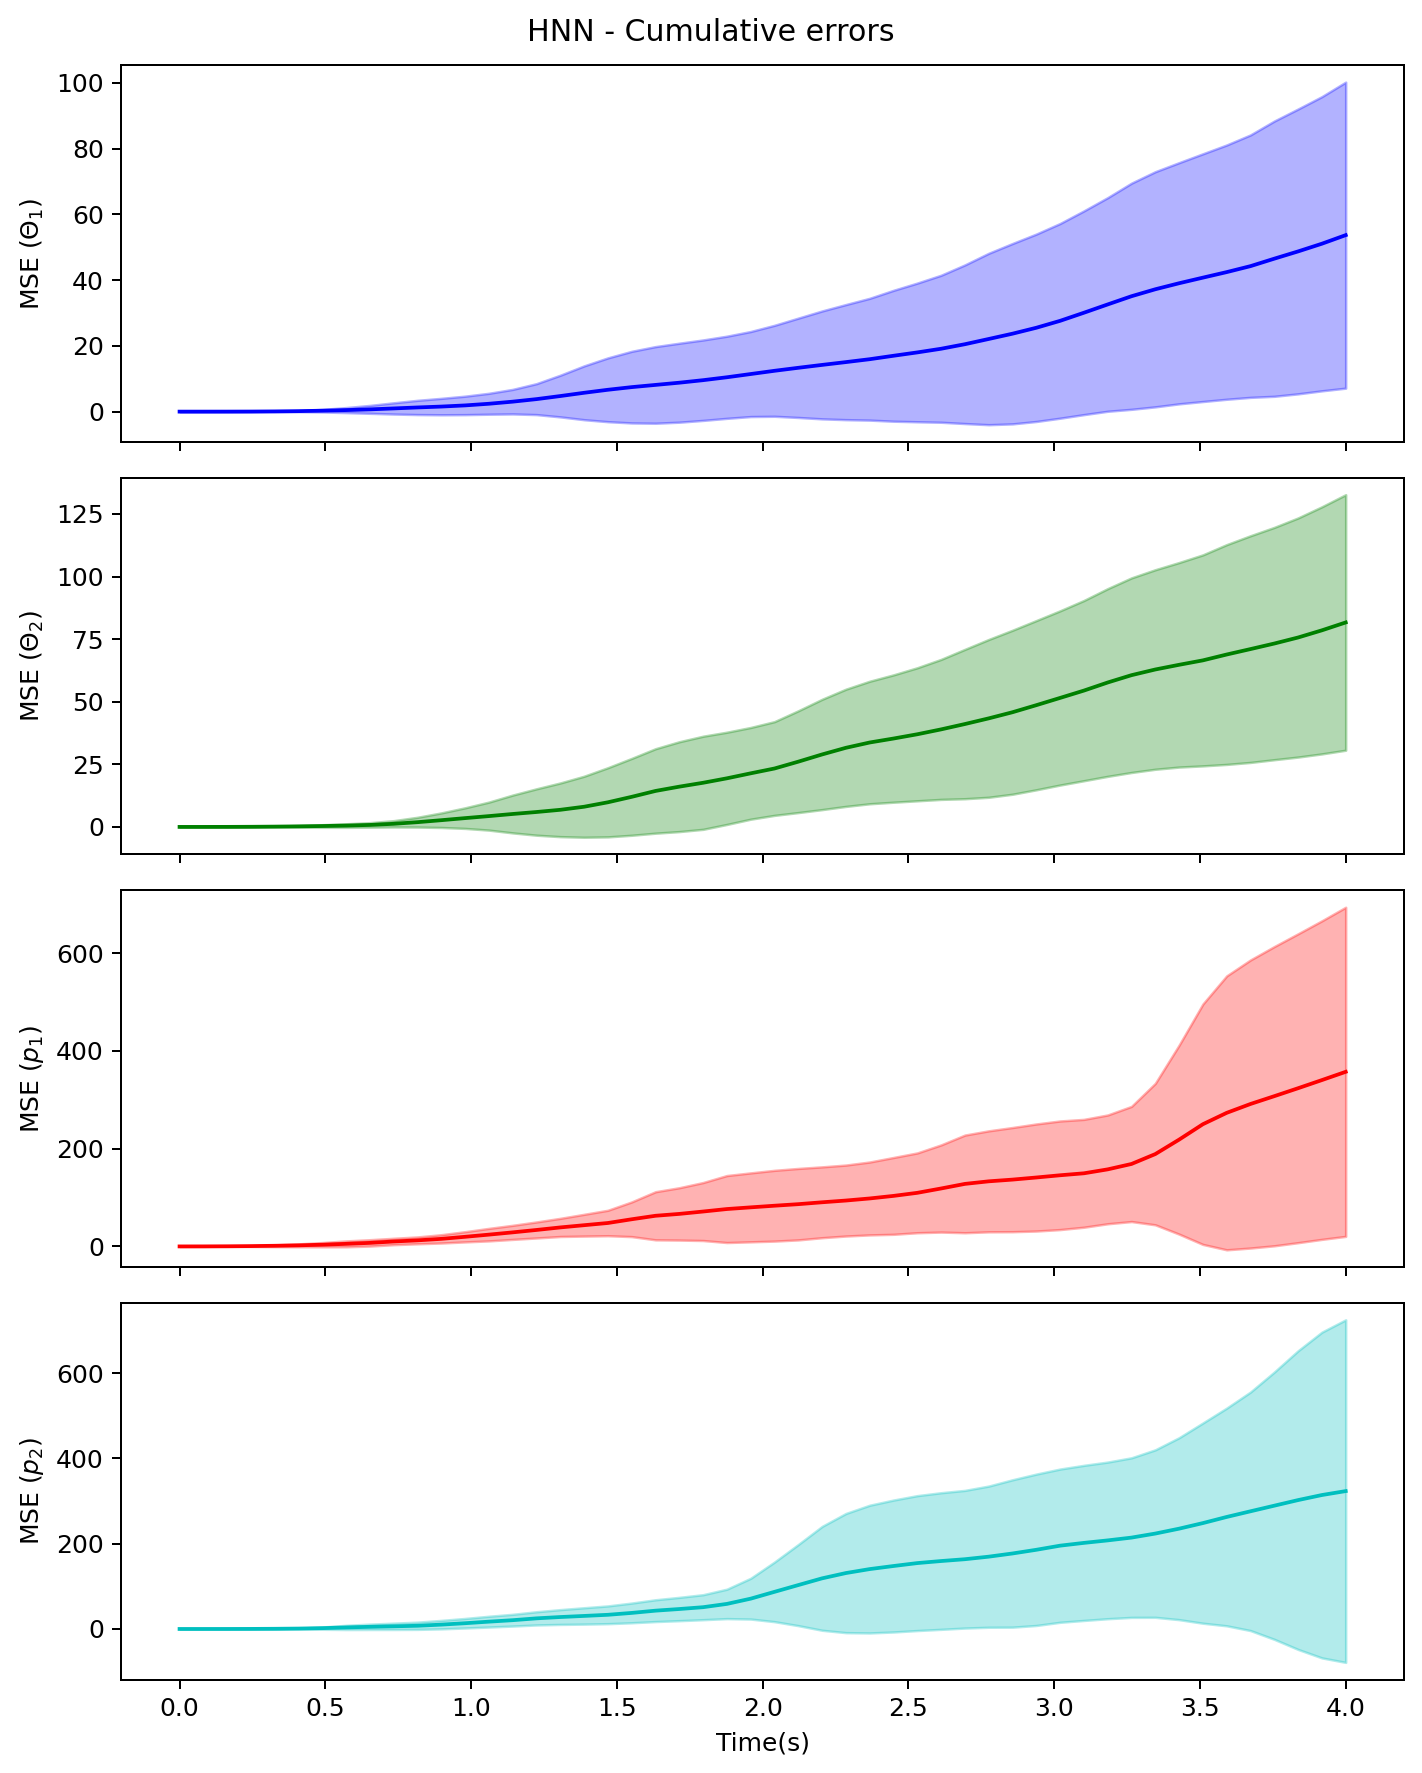

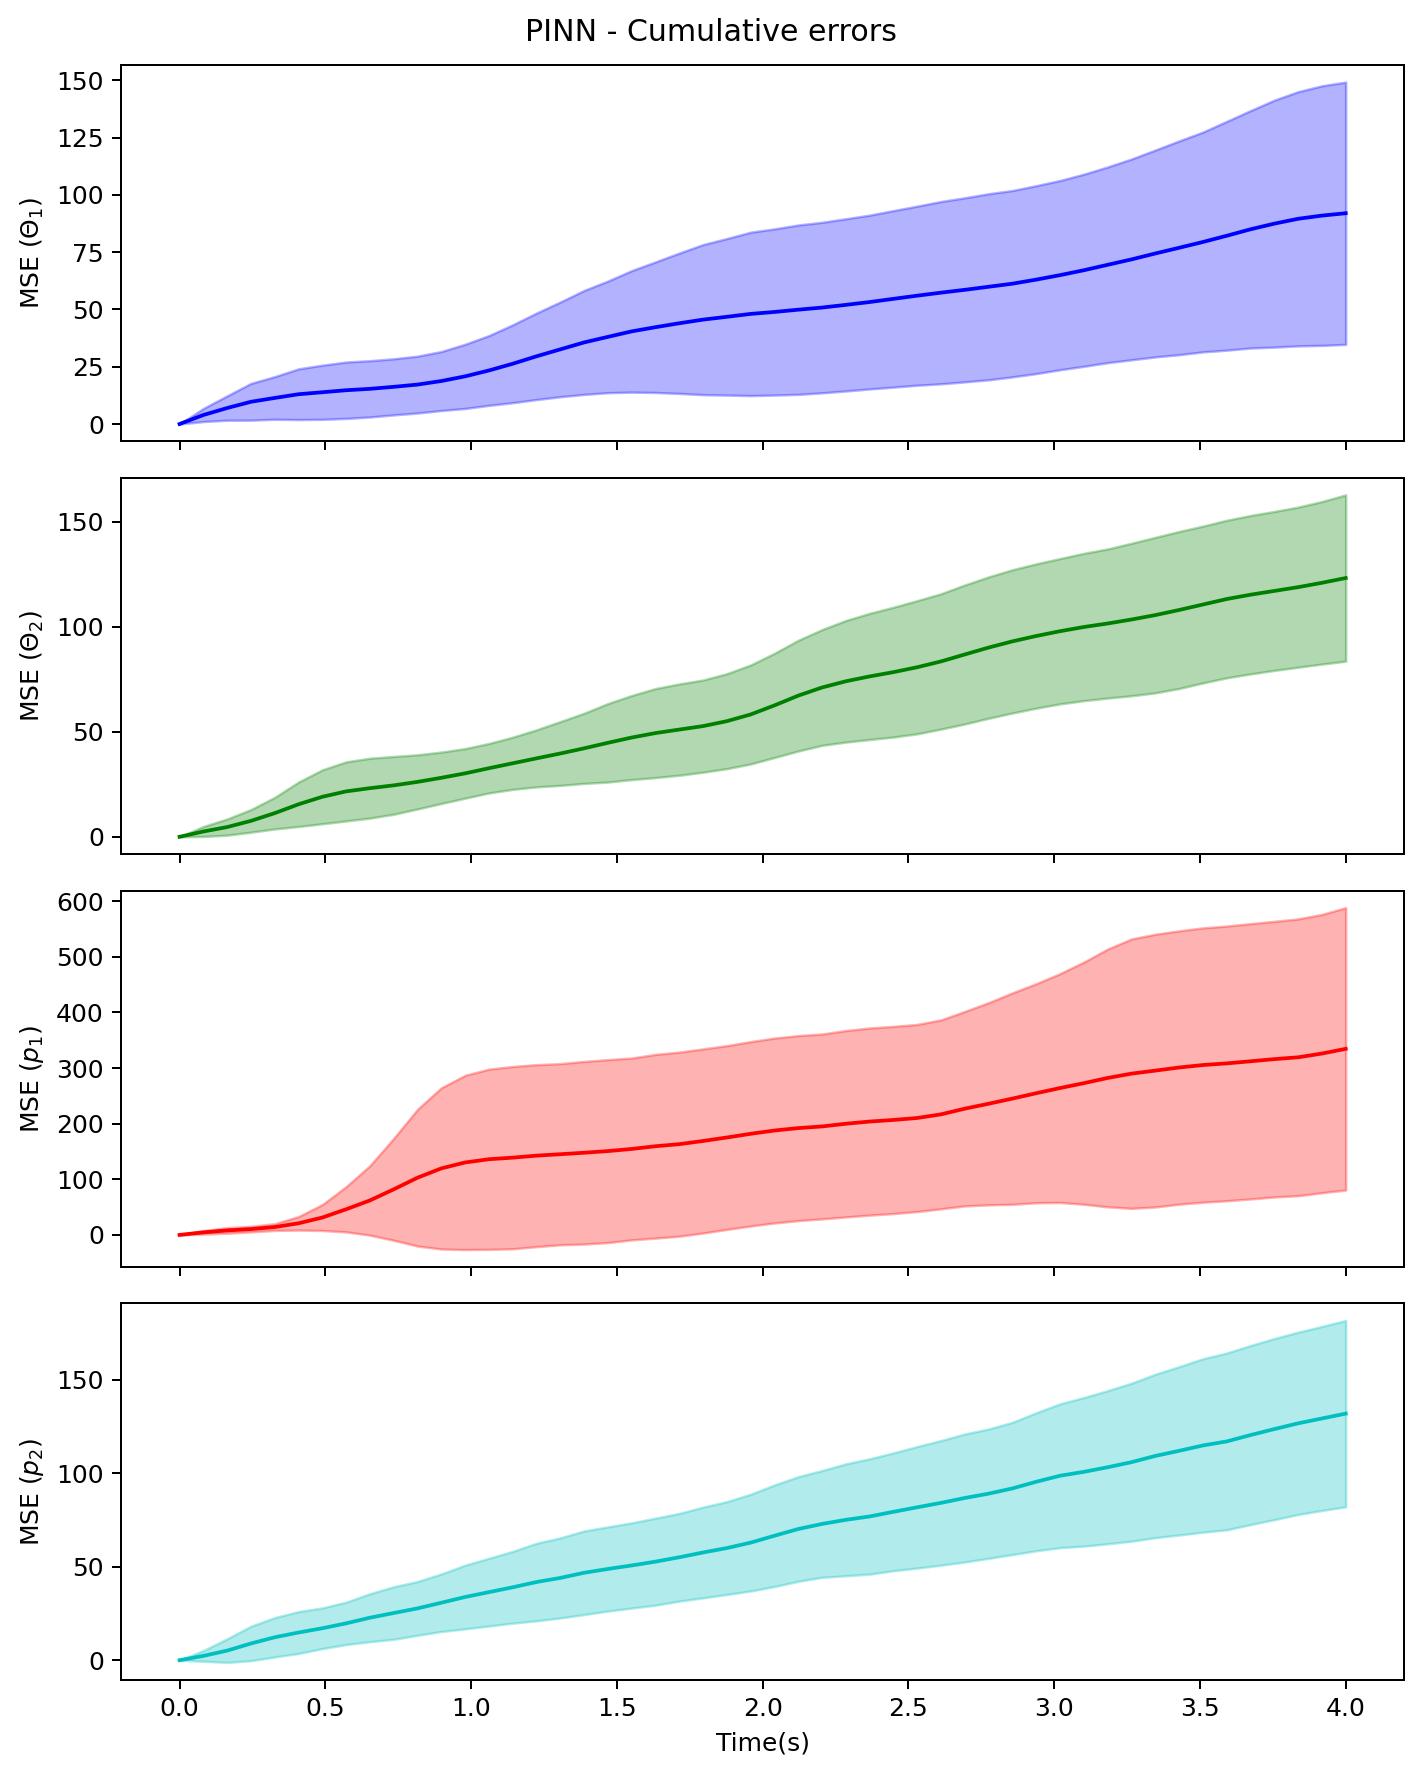

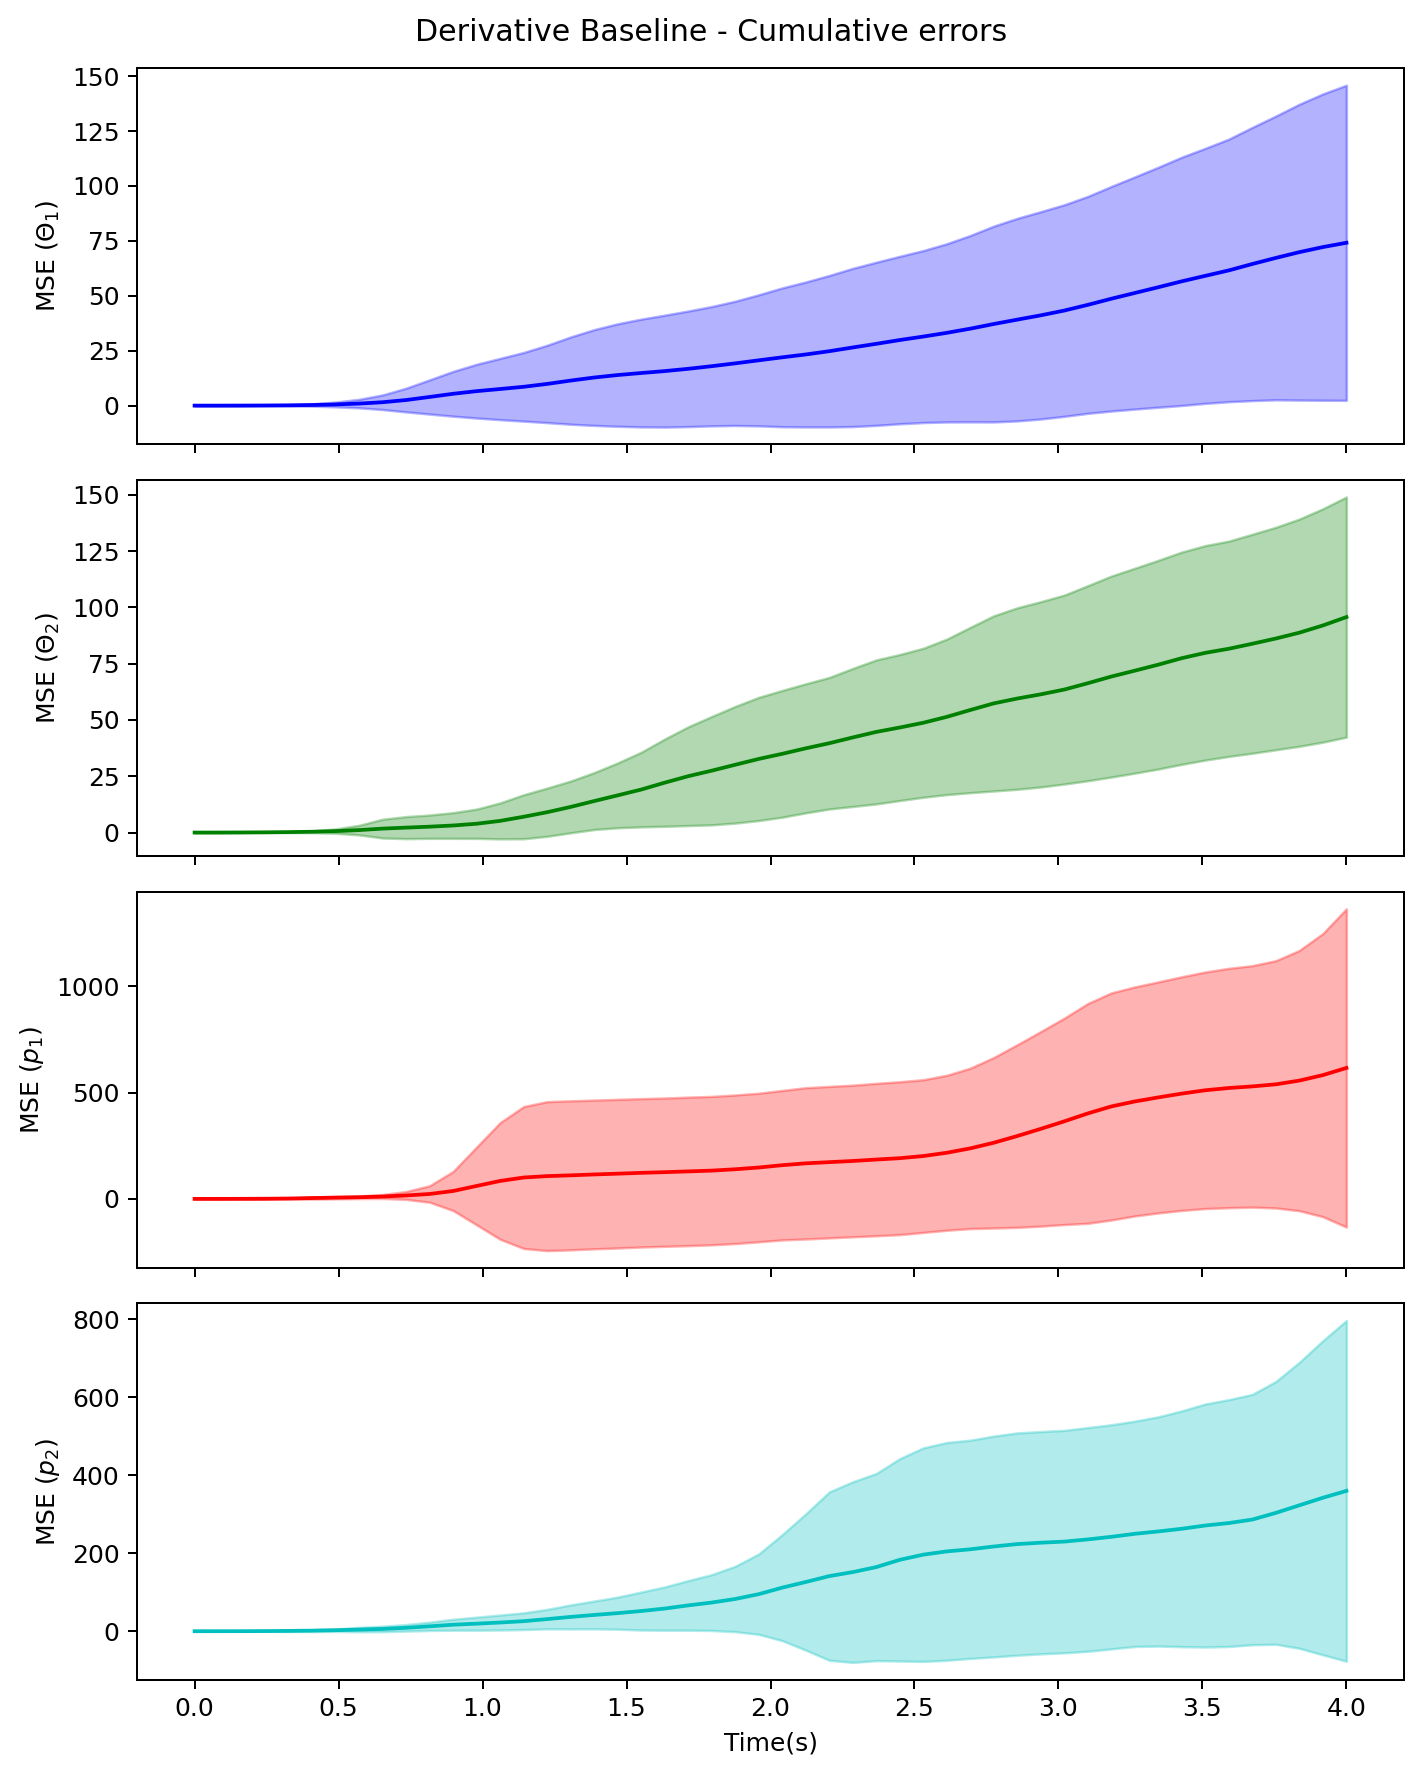

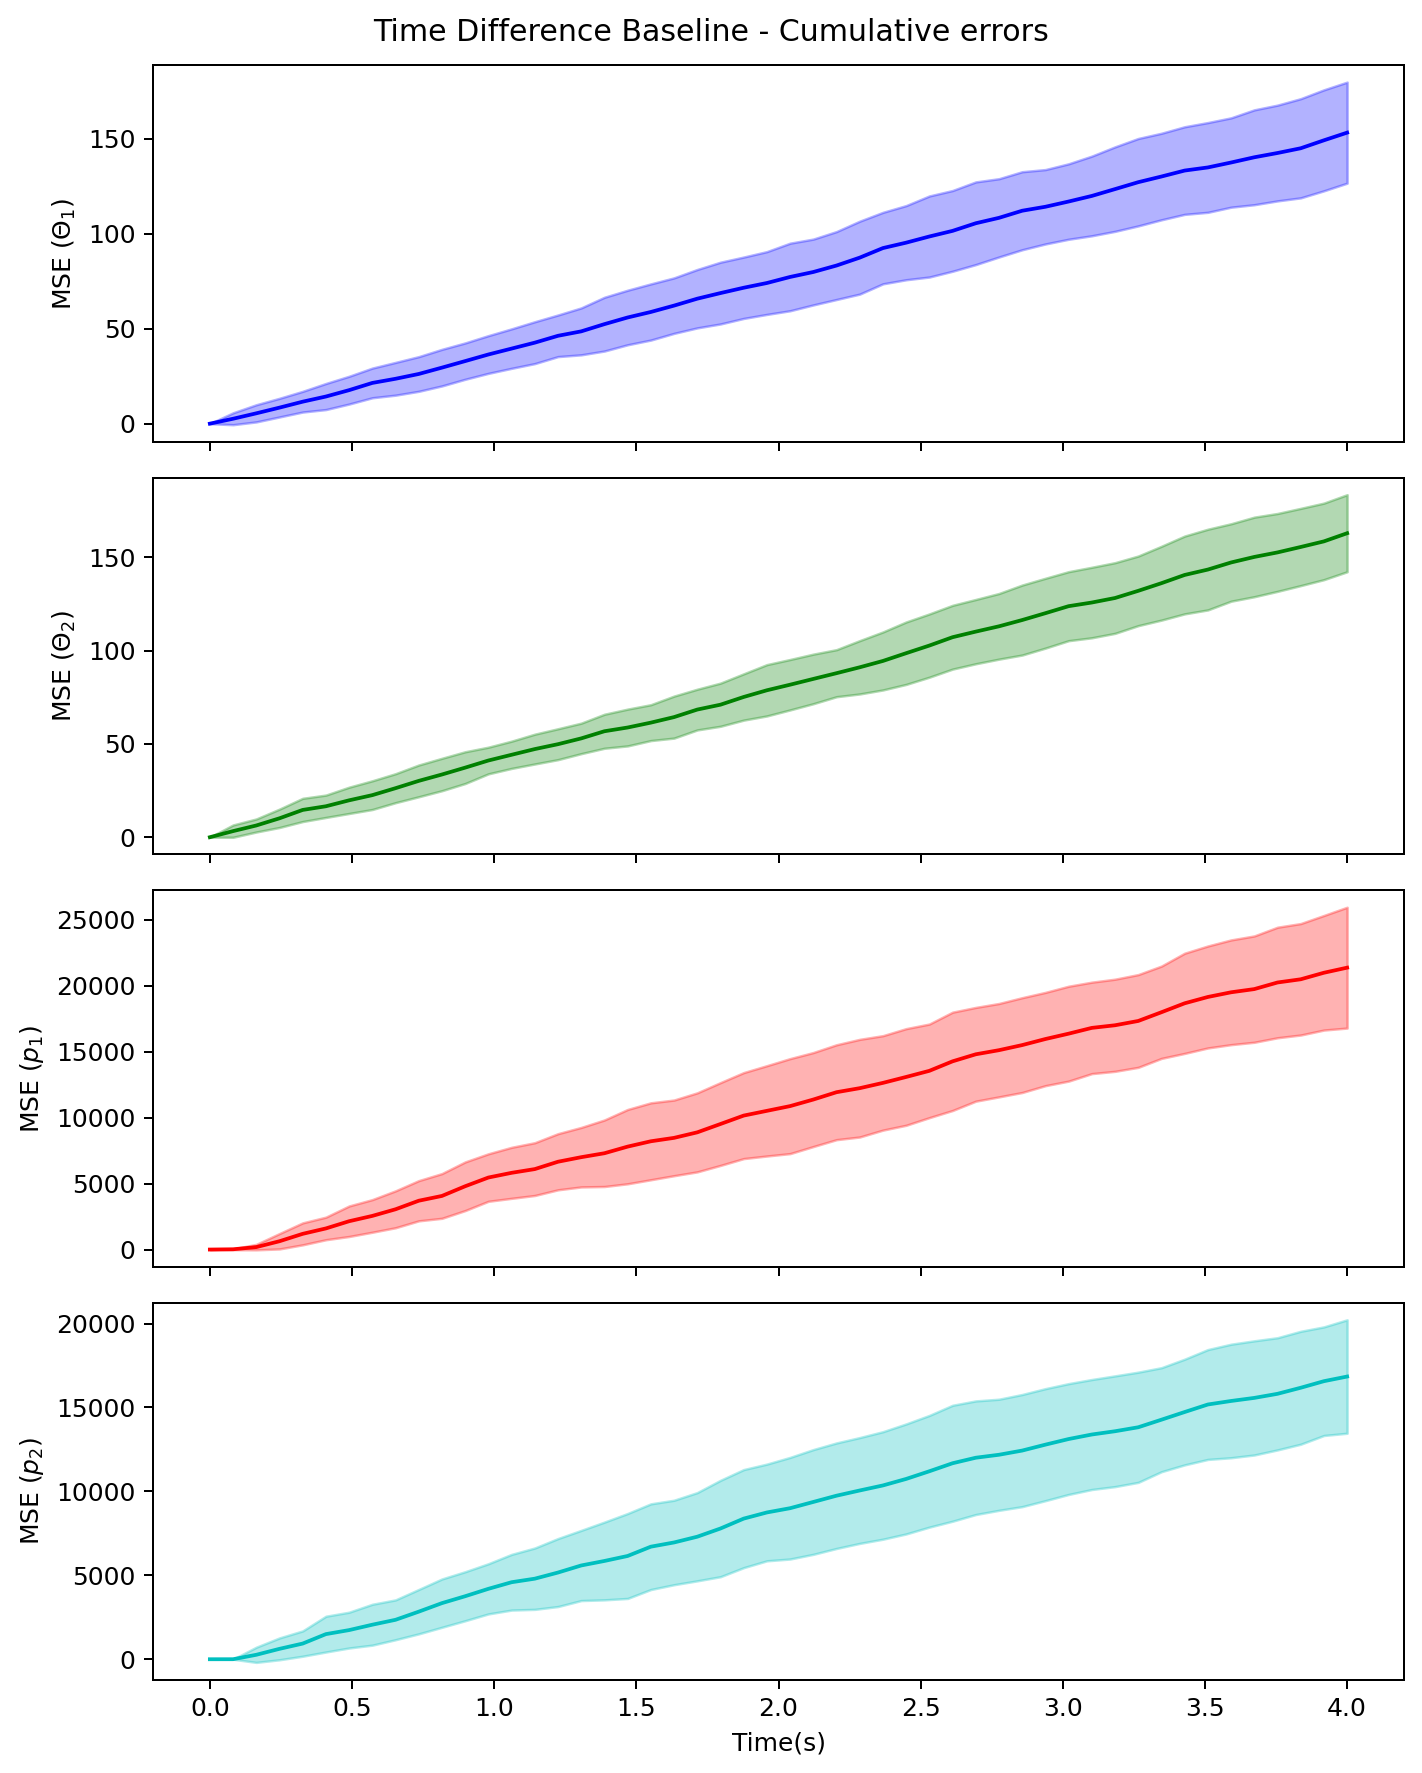

In [48]:
data = errors_coordinates
display_names = {
    'hnn': 'HNN',
    'pinn': 'PINN',
    'baseline': 'Derivative Baseline',
    'time_diff': 'Time Difference Baseline'
}
for i, model_name in enumerate(models):
    error_name = f"{model_name} - Cumulative errors"
    plot_title = f"{display_names[model_name]} - Cumulative errors"
    visualize_mean_error(data[i], ""f"{model_name}/"f"{error_name}", plot_title)

torch.Size([20, 4, 50])


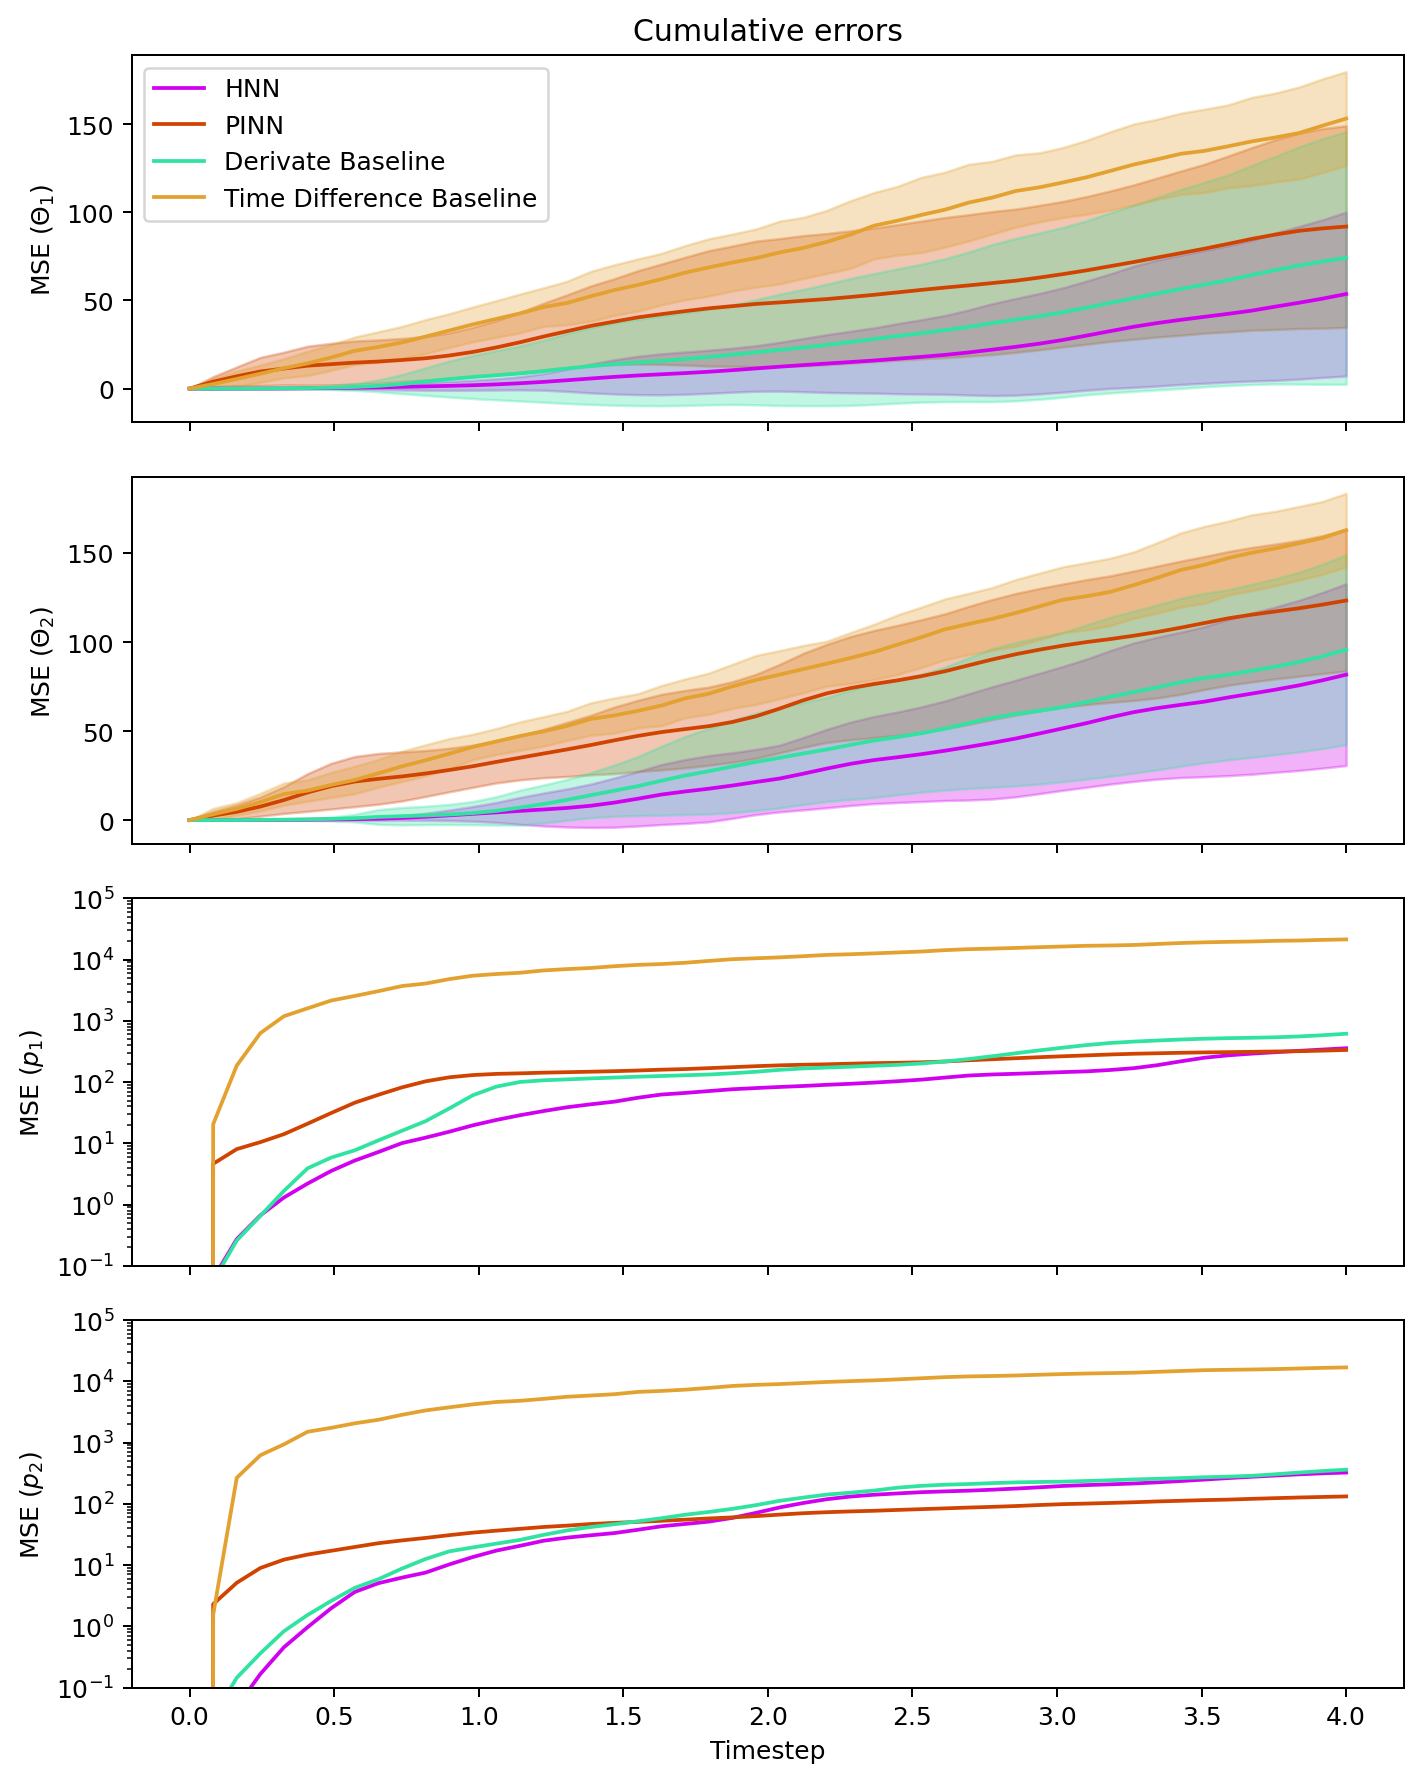

In [49]:
data = errors_coordinates
error_name = "Cumulative errors"
print(data[0].shape)
visualize_mean_errors(data, error_name)